In [69]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

import SimpSOM as sps
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

### Read in Data

In [35]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")
df.head()

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


code                                                url  \
0   3087  http://world-en.openfoodfacts.org/product/0000...   
1   4530  http://world-en.openfoodfacts.org/product/0000...   
2   4559  http://world-en.openfoodfacts.org/product/0000...   
3  16087  http://world-en.openfoodfacts.org/product/0000...   
4  16094  http://world-en.openfoodfacts.org/product/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...                         NaN   
1          NaN      NaN  ...                         NaN   
2          NaN      NaN  ...                         NaN   
3          NaN      NaN  ...                         NaN   
4          NaN      NaN  ...                         NaN   

  fruits-vegetables-nuts-estimate_100g collagen-meat-protein-ratio_100g  \
0                                  NaN                              NaN   
1                                  NaN                              NaN   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   

  cocoa_100g chlorophyl_100g carbon-footprint_100g nutrition-score-fr_100g  \
0        NaN             NaN                   NaN                     NaN   
1        NaN             NaN                   NaN                    14.0   
2        NaN             NaN                   NaN                     0.0   
3        NaN             NaN                   NaN                    12.0   
4        NaN             NaN                   NaN                     NaN   

  nutrition-score-uk_100g glycemic-index_100g water-hardness_100g  
0                     NaN                 NaN                 NaN  
1                    14.0                 NaN                 NaN  
2                     0.0                 NaN                 NaN  
3                    12.0                 NaN                 NaN  
4                     NaN                 NaN                 NaN  

[5 rows x 163 columns]

In [36]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

## Clean Ingredients

In [37]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clean_df = df[keep_cols]
clean_df = clean_df.dropna()

In [38]:
clean_ingre = lambda s: " ".join( map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )

In [39]:
clean_df["ingredients_text"] = [clean_ingre(i) for i in clean_df["ingredients_text"]]

### Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are **not** in the the most common words list are dropped

In [40]:
all_words = [i for ing in clean_df['ingredients_text'] for i in ing.split()]

In [41]:
most_common_words = dict(Counter(all_words).most_common(1000))

In [42]:
clean_df = clean_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clean_df['ingredients_text']]]

In [43]:
clean_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...               60.71   
30                                     organic-coconut               53.33   
38                                     organic-coconut               24.00   
148                    cranberries sugar sunflower-oil               83.33   
149                            apricots sulfur-dioxide               62.50   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  
2           7.1        17.86          17.86     17.86                0.00  
30          6.7         6.67           6.67     30.00               26.67  
38         16.0         7.00           6.00     65.00               57.00  
148        10.0        66.67           0.00      0.00                0.00  
149         7.5        52.50           2.50      0.00                0.00

In [44]:
df.shape

(356027, 163)

In [45]:
clean_df.shape

(13091, 7)

### Remove outliers

In [46]:
clean_df = clean_df[(np.abs(stats.zscore(clean_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [47]:
clean_df.describe()

carbohydrates_100g    fiber_100g   sugars_100g  proteins_100g  \
count        12277.000000  12277.000000  12277.000000   12277.000000   
mean            28.127085      2.700839     11.176865       9.885555   
std             29.103303      3.504133     18.002026       9.279081   
min              0.000000      0.000000     -1.200000       0.000000   
25%              3.700000      0.000000      0.000000       1.600000   
50%             14.290000      1.600000      3.570000       7.000000   
75%             56.250000      3.600000     10.620000      17.650000   
max            100.000000     18.000000     73.330000      38.460000   

          fat_100g  saturated-fat_100g  
count  12277.00000        12277.000000  
mean      15.22132            4.956619  
std       19.13315            7.077012  
min        0.00000            0.000000  
25%        0.00000            0.000000  
50%        3.33000            0.340000  
75%       28.57000            7.140000  
max       82.14000           30.000000

### Center and Scale

In [48]:
for col in keep_cols[1:]:
    clean_df[col] = scale(np.array(clean_df[col]))

In [49]:
clean_df.describe()

carbohydrates_100g    fiber_100g   sugars_100g  proteins_100g  \
count        1.227700e+04  1.227700e+04  1.227700e+04   1.227700e+04   
mean         1.111218e-16 -4.167067e-17  9.260148e-17   4.282818e-17   
std          1.000041e+00  1.000041e+00  1.000041e+00   1.000041e+00   
min         -9.664962e-01 -7.707895e-01 -6.875542e-01  -1.065403e+00   
25%         -8.393577e-01 -7.707895e-01 -6.208924e-01  -8.929648e-01   
50%         -4.754666e-01 -3.141672e-01 -4.225733e-01  -3.109869e-01   
75%          9.663529e-01  2.566106e-01 -3.093475e-02   8.368028e-01   
max          2.469680e+00  4.366211e+00  3.452704e+00   3.079573e+00   

           fat_100g  saturated-fat_100g  
count  1.227700e+04        1.227700e+04  
mean   3.935563e-17        1.574225e-16  
std    1.000041e+00        1.000041e+00  
min   -7.955794e-01       -7.004115e-01  
25%   -7.955794e-01       -7.004115e-01  
50%   -6.215288e-01       -6.523667e-01  
75%    6.977013e-01        3.085299e-01  
max    3.497668e+00        3.538838e+00

## Summary Plots

In [50]:
plot_df = clean_df.join(df['nutrition-score-fr_100g']).dropna()

In [51]:
plot_df.columns = ['ingr', 'carbohydrates', 'fiber', 'sugars', 'proteins', 'fat', 'saturated fat', 'nutrition score']

In [52]:
plt.style.use('fivethirtyeight')

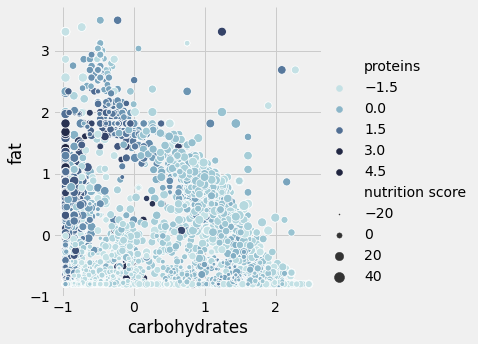

In [53]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(data=plot_df,x="carbohydrates", y="fat", hue="proteins", 
            size='nutrition score', palette=cmap, sizes=(1, 100))

In [54]:
plot_df['new score'] = list(map(lambda x : "unhealthy" if x > 6 else 'healthy', plot_df['nutrition score']))

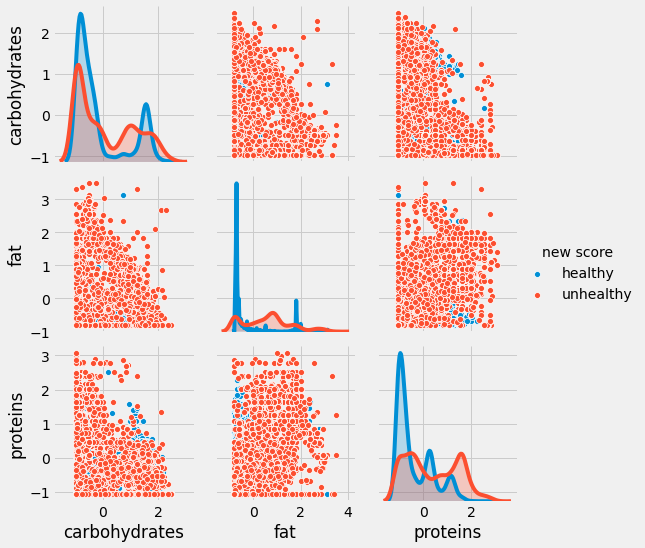

In [55]:
sns.pairplot(plot_df[['carbohydrates', 'fat', 'proteins', 'new score']], hue = 'new score')

In [56]:
# clean_df.to_csv('/Users/gabrieltaylor/Python/STAT542/STAT542/gabet/clean_df.csv')

## How many ingredients are we leaving out by only keeping the top 1000?

In [57]:
most_common_words_df = pd.DataFrame(most_common_words, index = [1])

In [58]:
most_common_words_df = most_common_words_df.transpose().reset_index()

In [59]:
most_common_words_df.columns = ['ingredient', 'freq']

In [60]:
sum(most_common_words_df['freq'] / len(all_words))

0.6305187681525436

#### We're still keeping 63% of the ingredients when only keeping the top 1000

In [61]:
most_common_words_df['dist'] = most_common_words_df['freq'] / len(all_words)

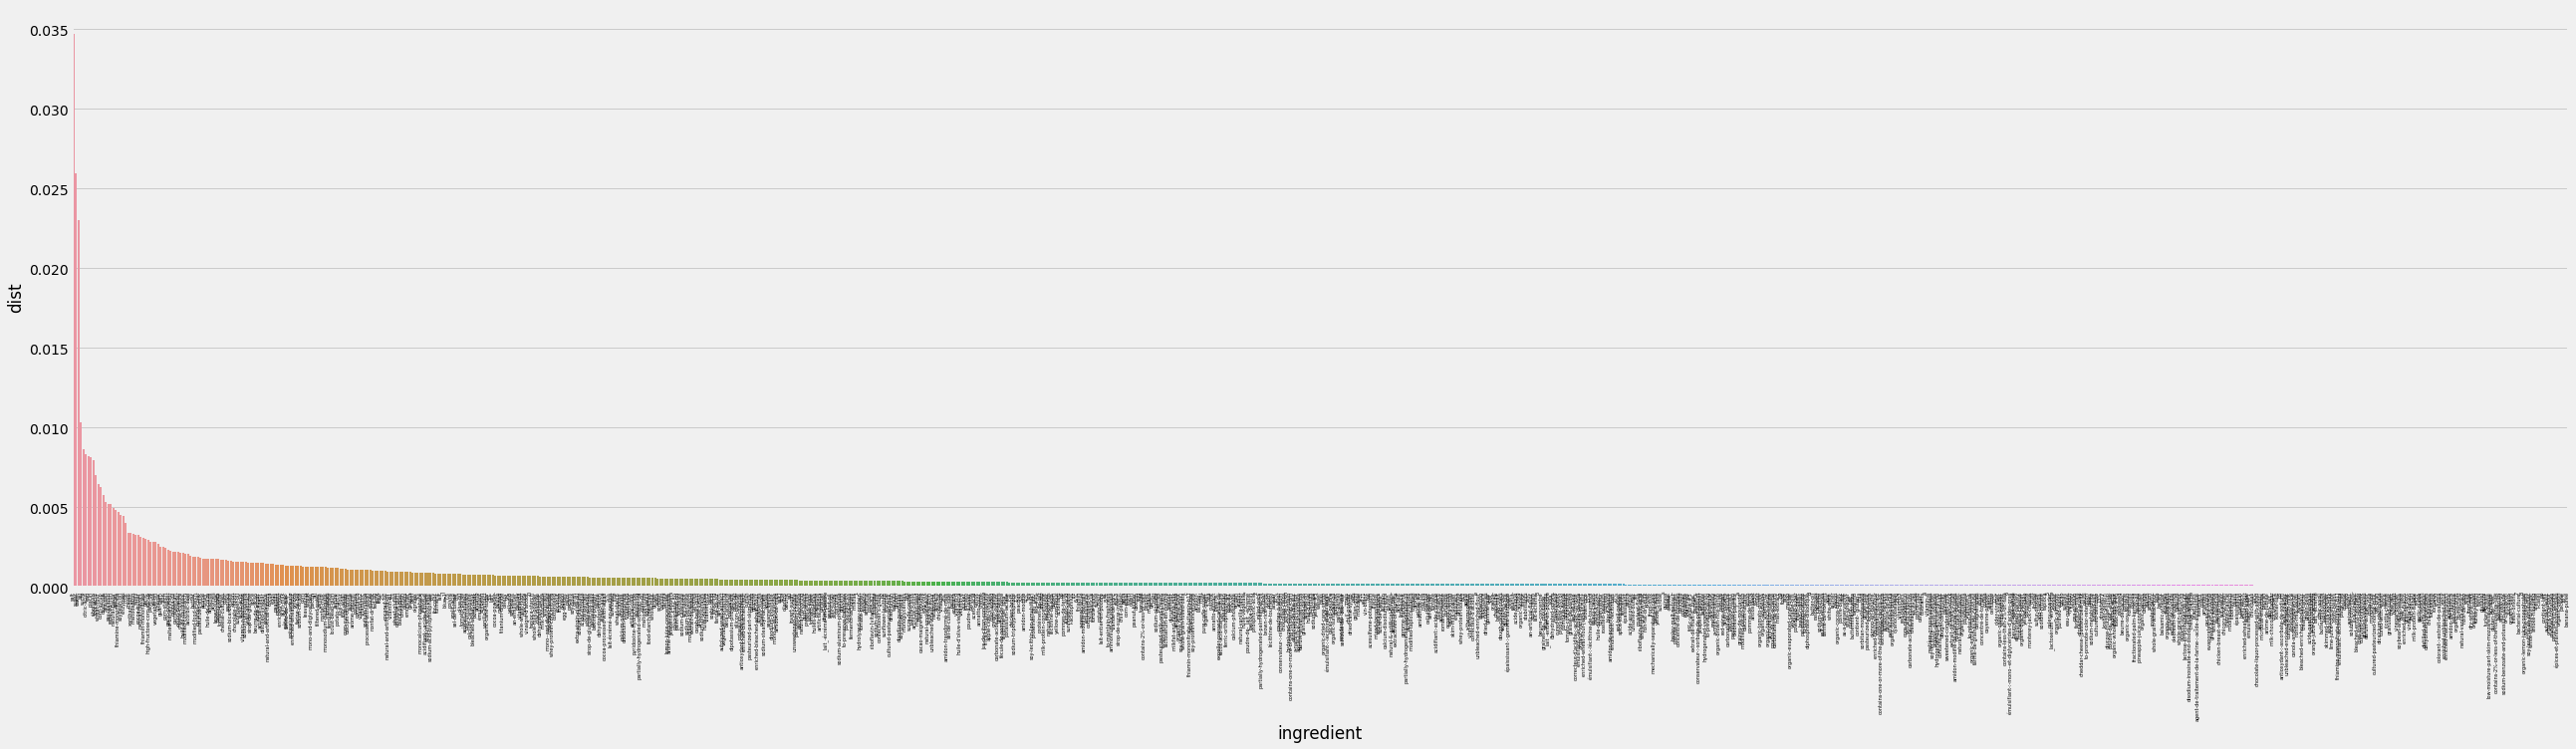

In [62]:
plt.figure(figsize=(40, 10))
sns.barplot(x = "ingredient", y = "dist", data = most_common_words_df)
plt.xticks(fontsize = 5, rotation = 90)
plt.show()

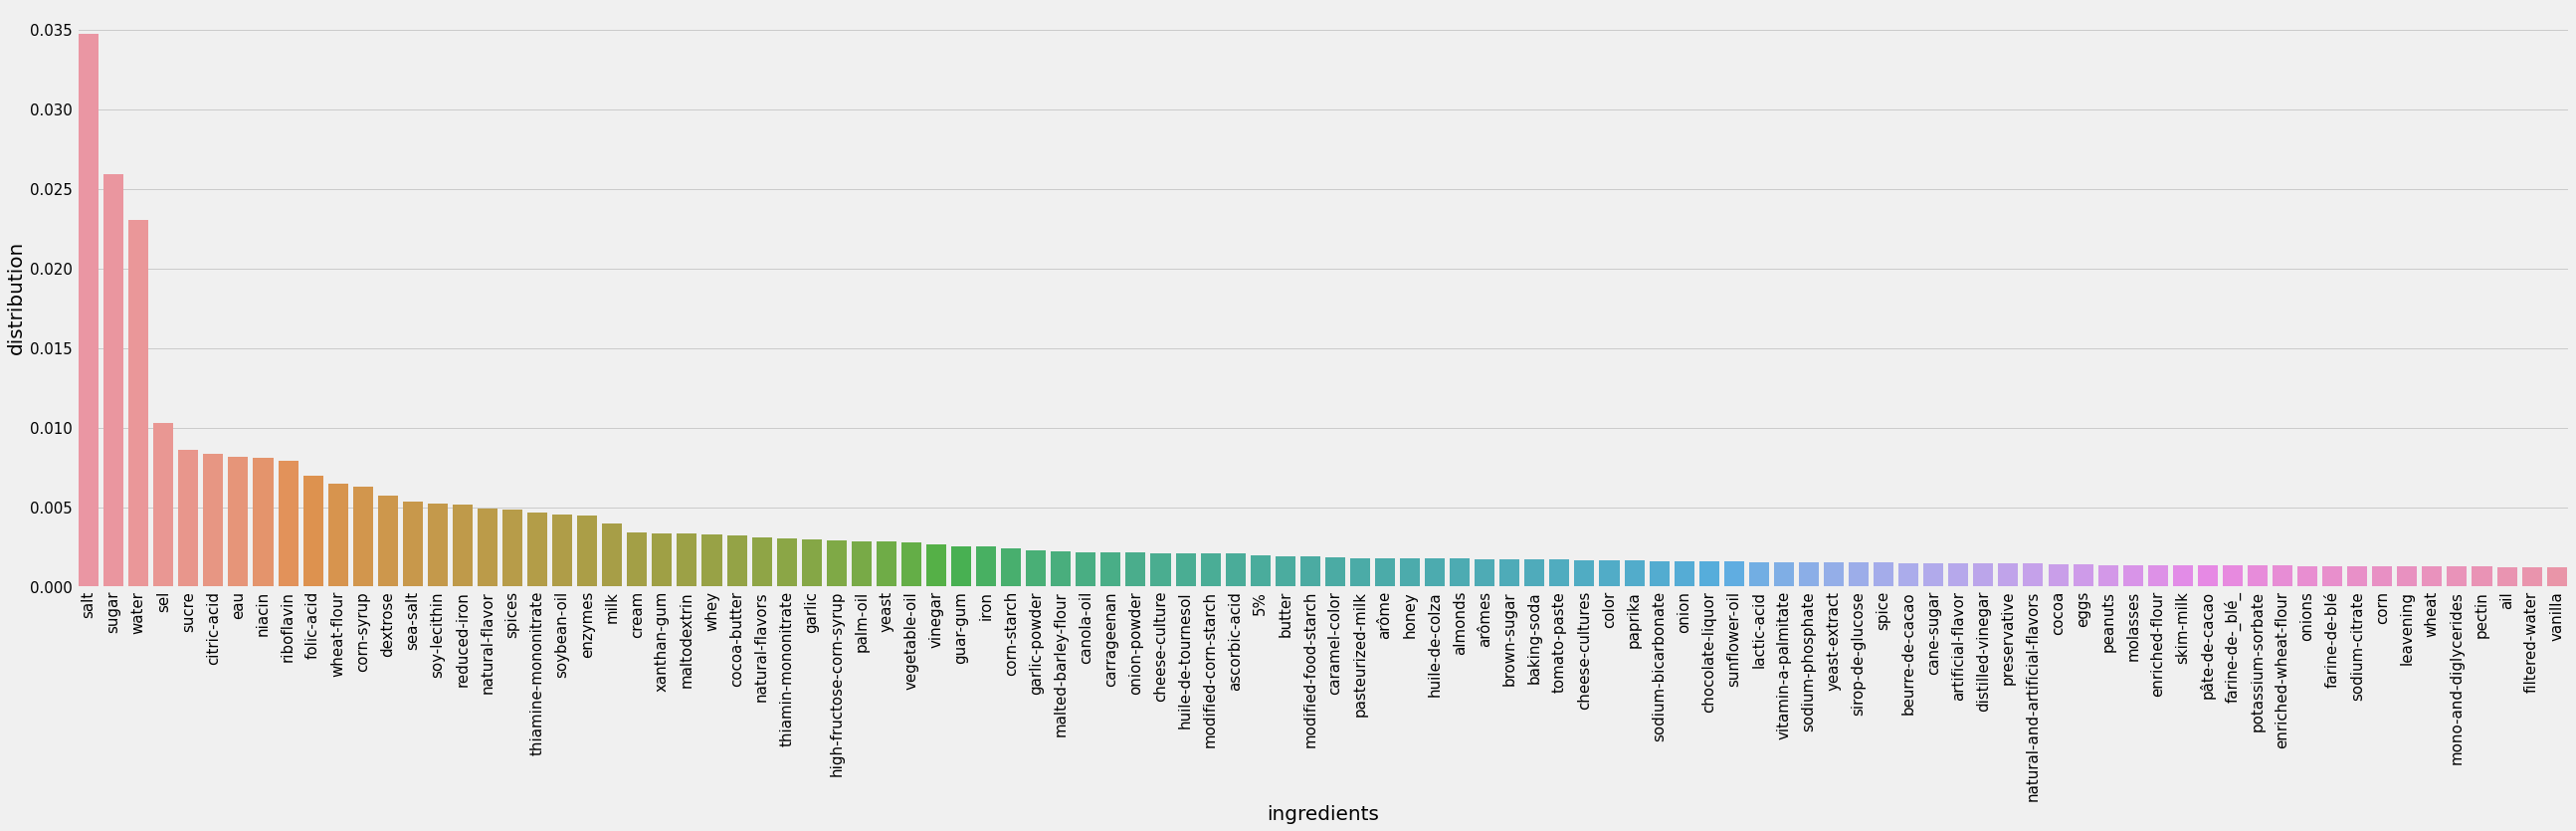

In [63]:
plt.figure(figsize=(40, 10))
sns.barplot(x = "ingredient", y = "dist", data = most_common_words_df.iloc[:100, :])
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.xlabel('ingredients', fontsize = 20)
plt.ylabel('distribution', fontsize = 20)
plt.show()

In [64]:
#clust_df = pd.read_csv('/Users/gabrieltaylor/Python/STAT542/STAT542/gabet/clean_df.csv', index_col = 0)
clust_df = clean_df

In [65]:
clust_df = clust_df.dropna()
clust_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...            1.119606   
30                                     organic-coconut            0.866017   
148                    cranberries sugar sunflower-oil            1.896869   
149                            apricots sulfur-dioxide            1.181114   
171                                            almonds           -0.279261   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  
2      1.255472     0.371259       0.859435  0.137917           -0.700412  
30     1.141316    -0.250363      -0.346552  0.772444            3.068281  
148    2.083100     3.082730      -1.065403 -0.795579           -0.700412  
149    1.369627     2.295565      -0.795968 -0.795579           -0.700412  
171    3.024883    -0.435906       1.090071  1.817792           -0.229855

# Unsupervised Task

## Self Organizing Map

In [66]:
Xst = clust_df.drop(["ingredients_text"], axis = 1).to_numpy()

In [ ]:
np.random.seed(1000)
net = sps.somNet(20, 20, Xst)
net.train(0.01, 20000)

Periodic Boundary Conditions inactive.
The weights will be initialised randomly.
Training SOM... 76% 

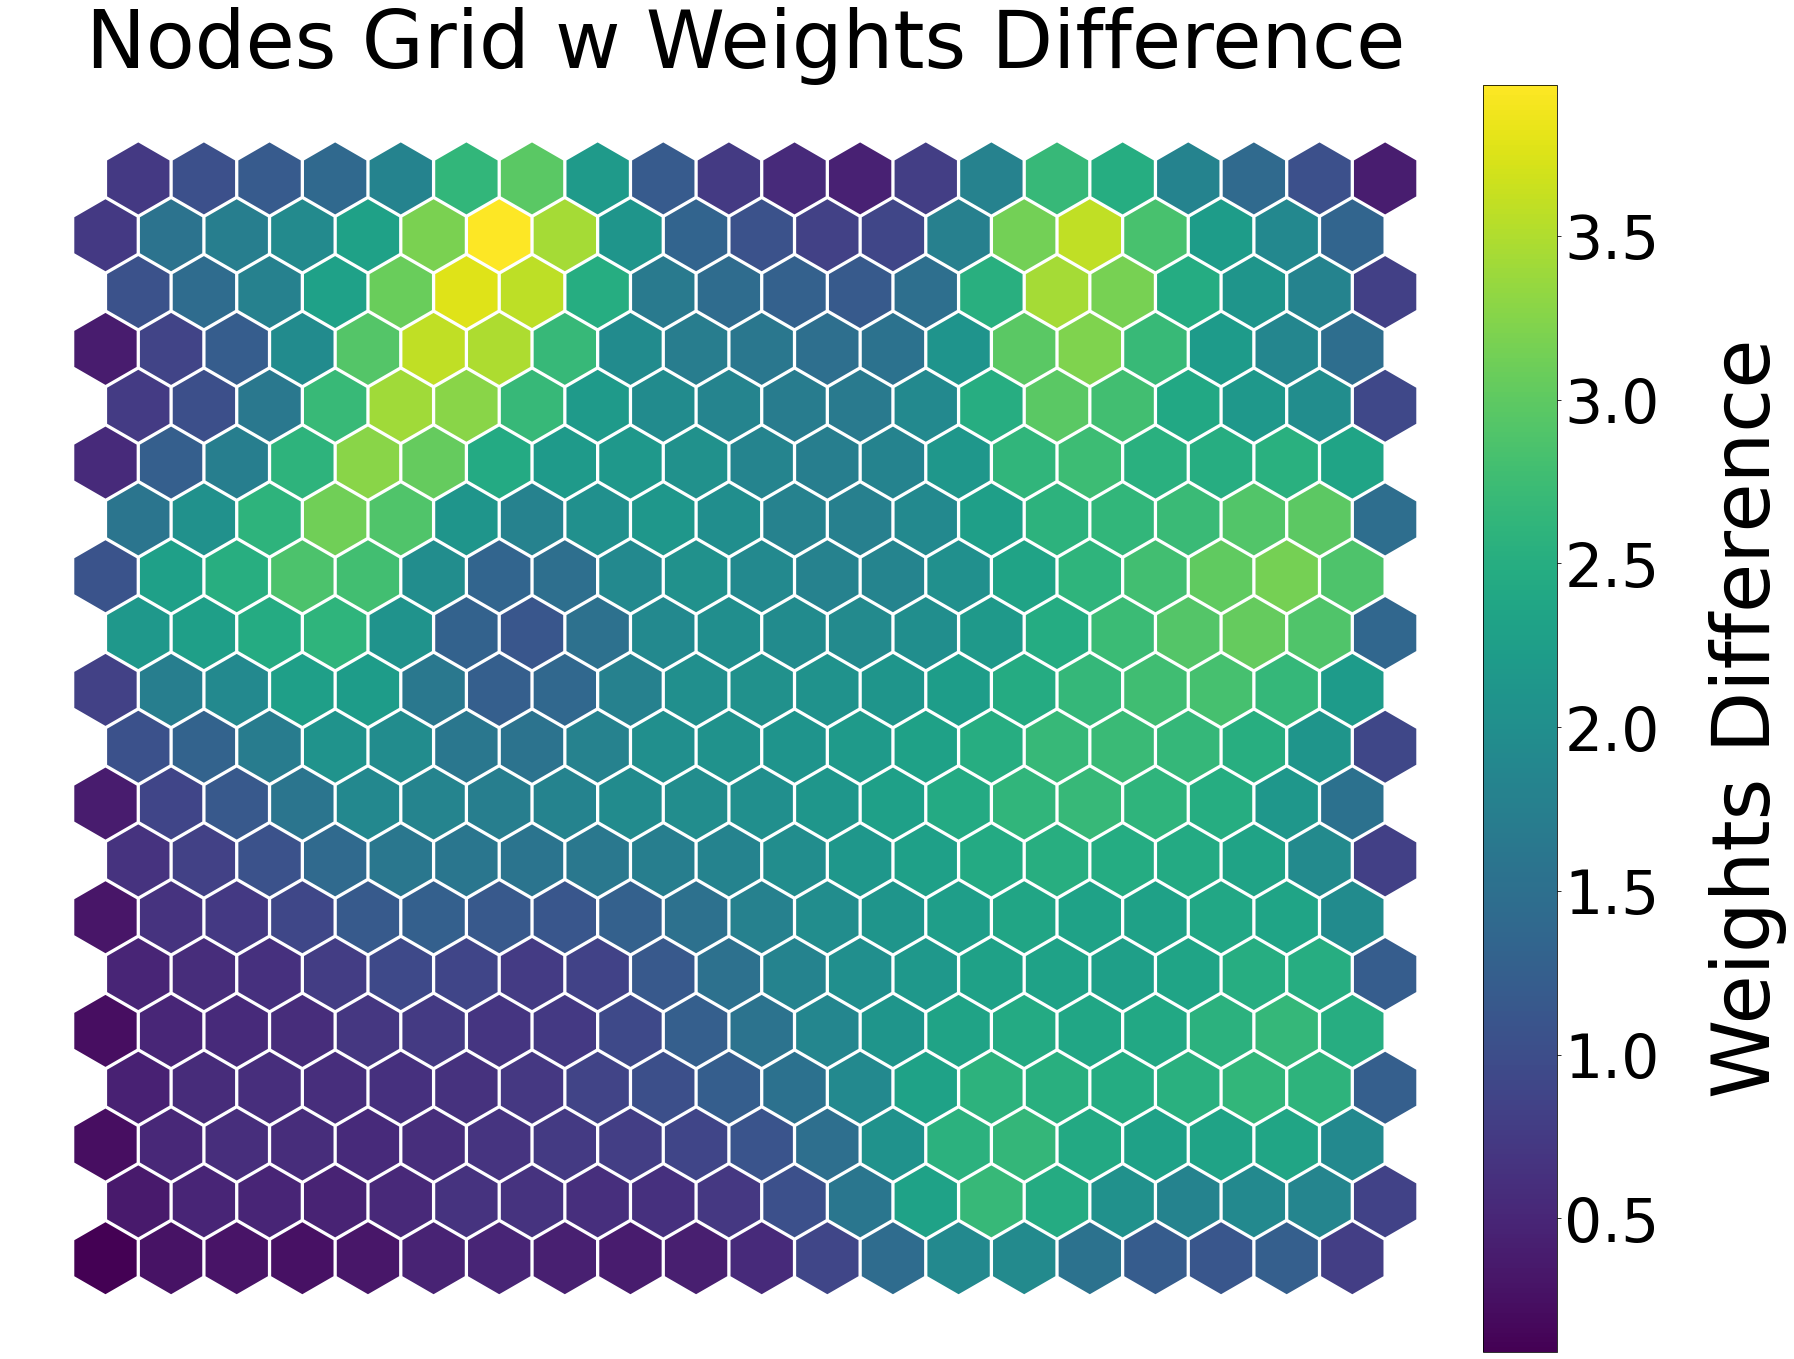

<Figure size 432x288 with 0 Axes>

In [17]:
net.diff_graph(show=True, printout=True)

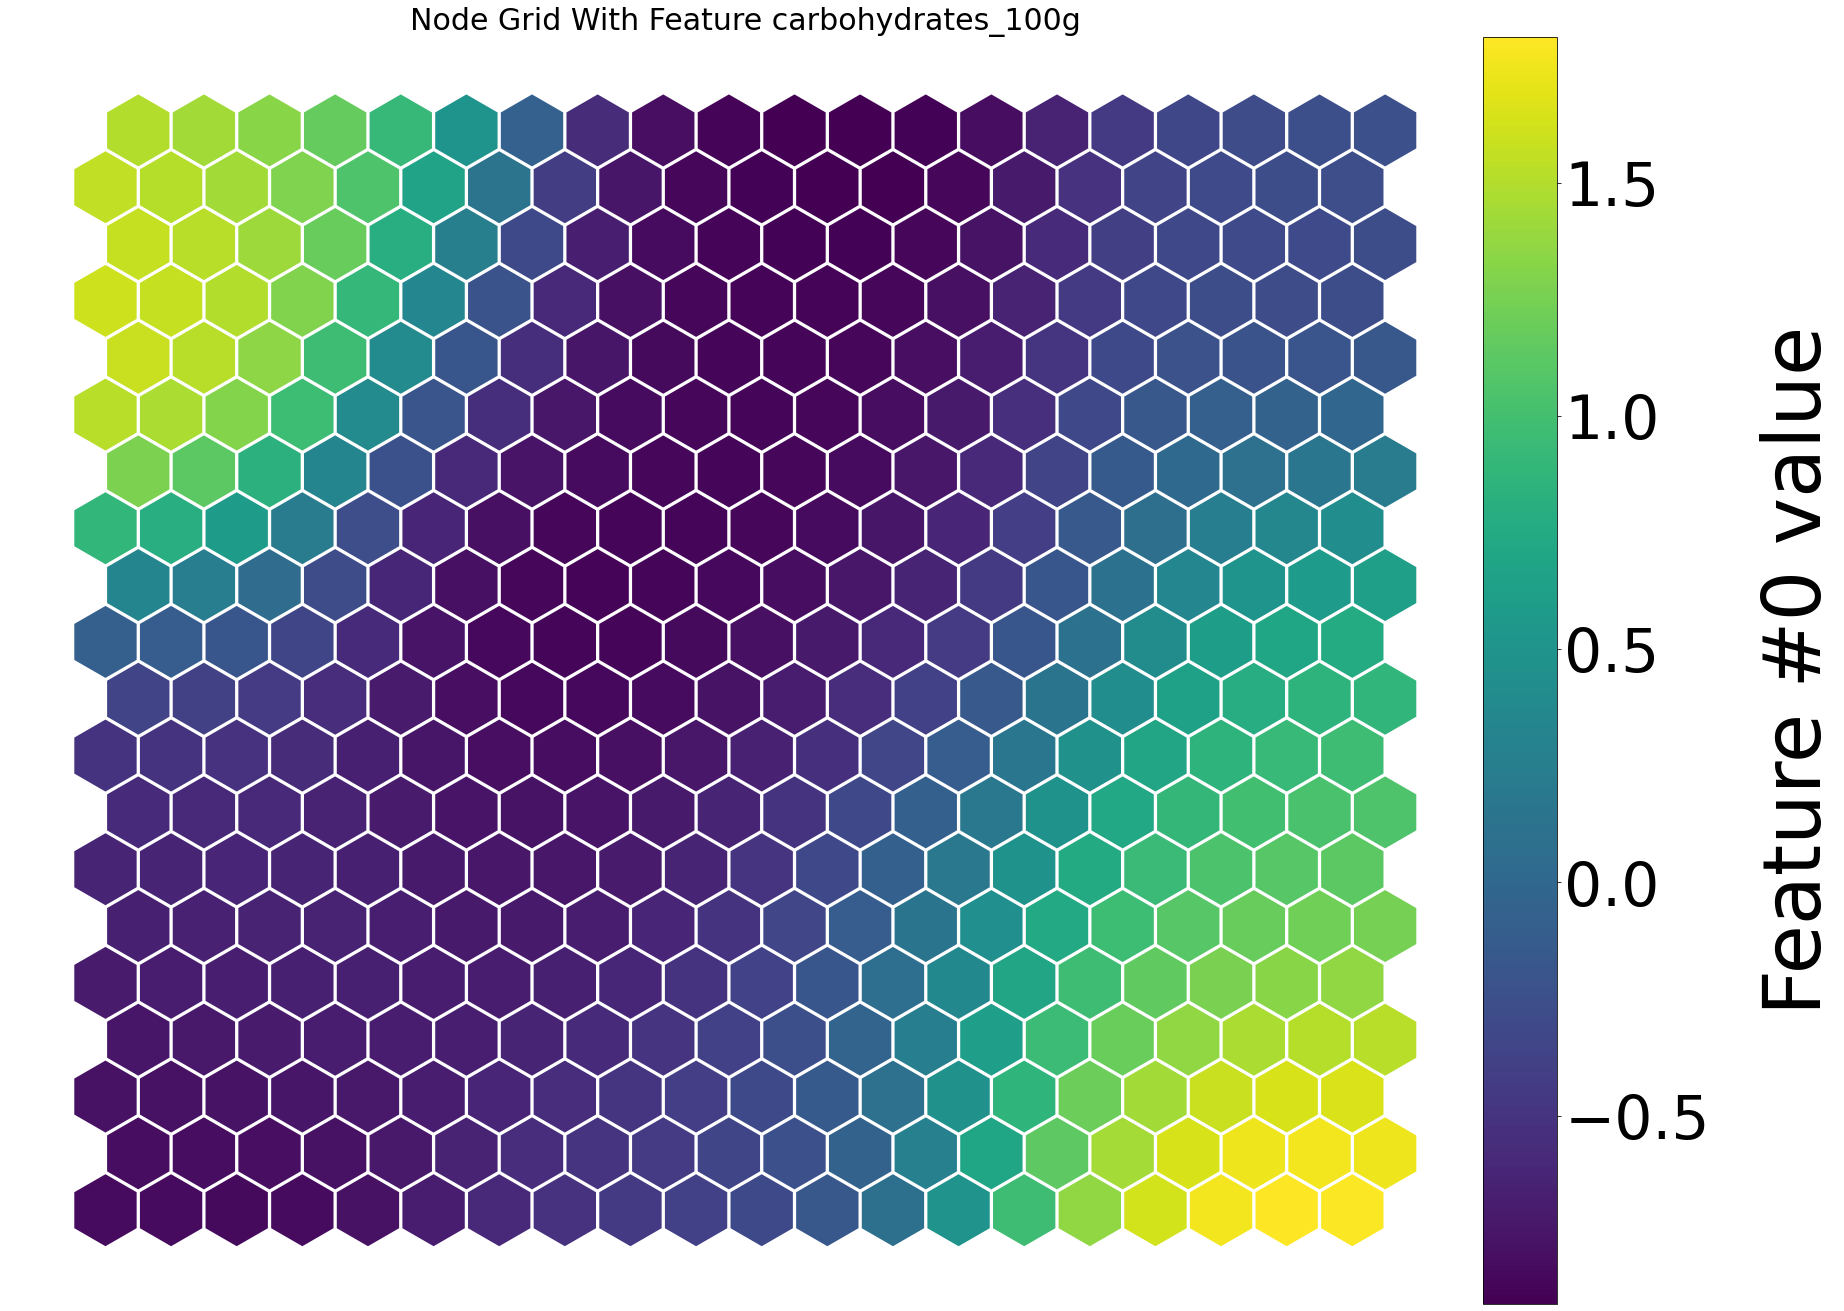

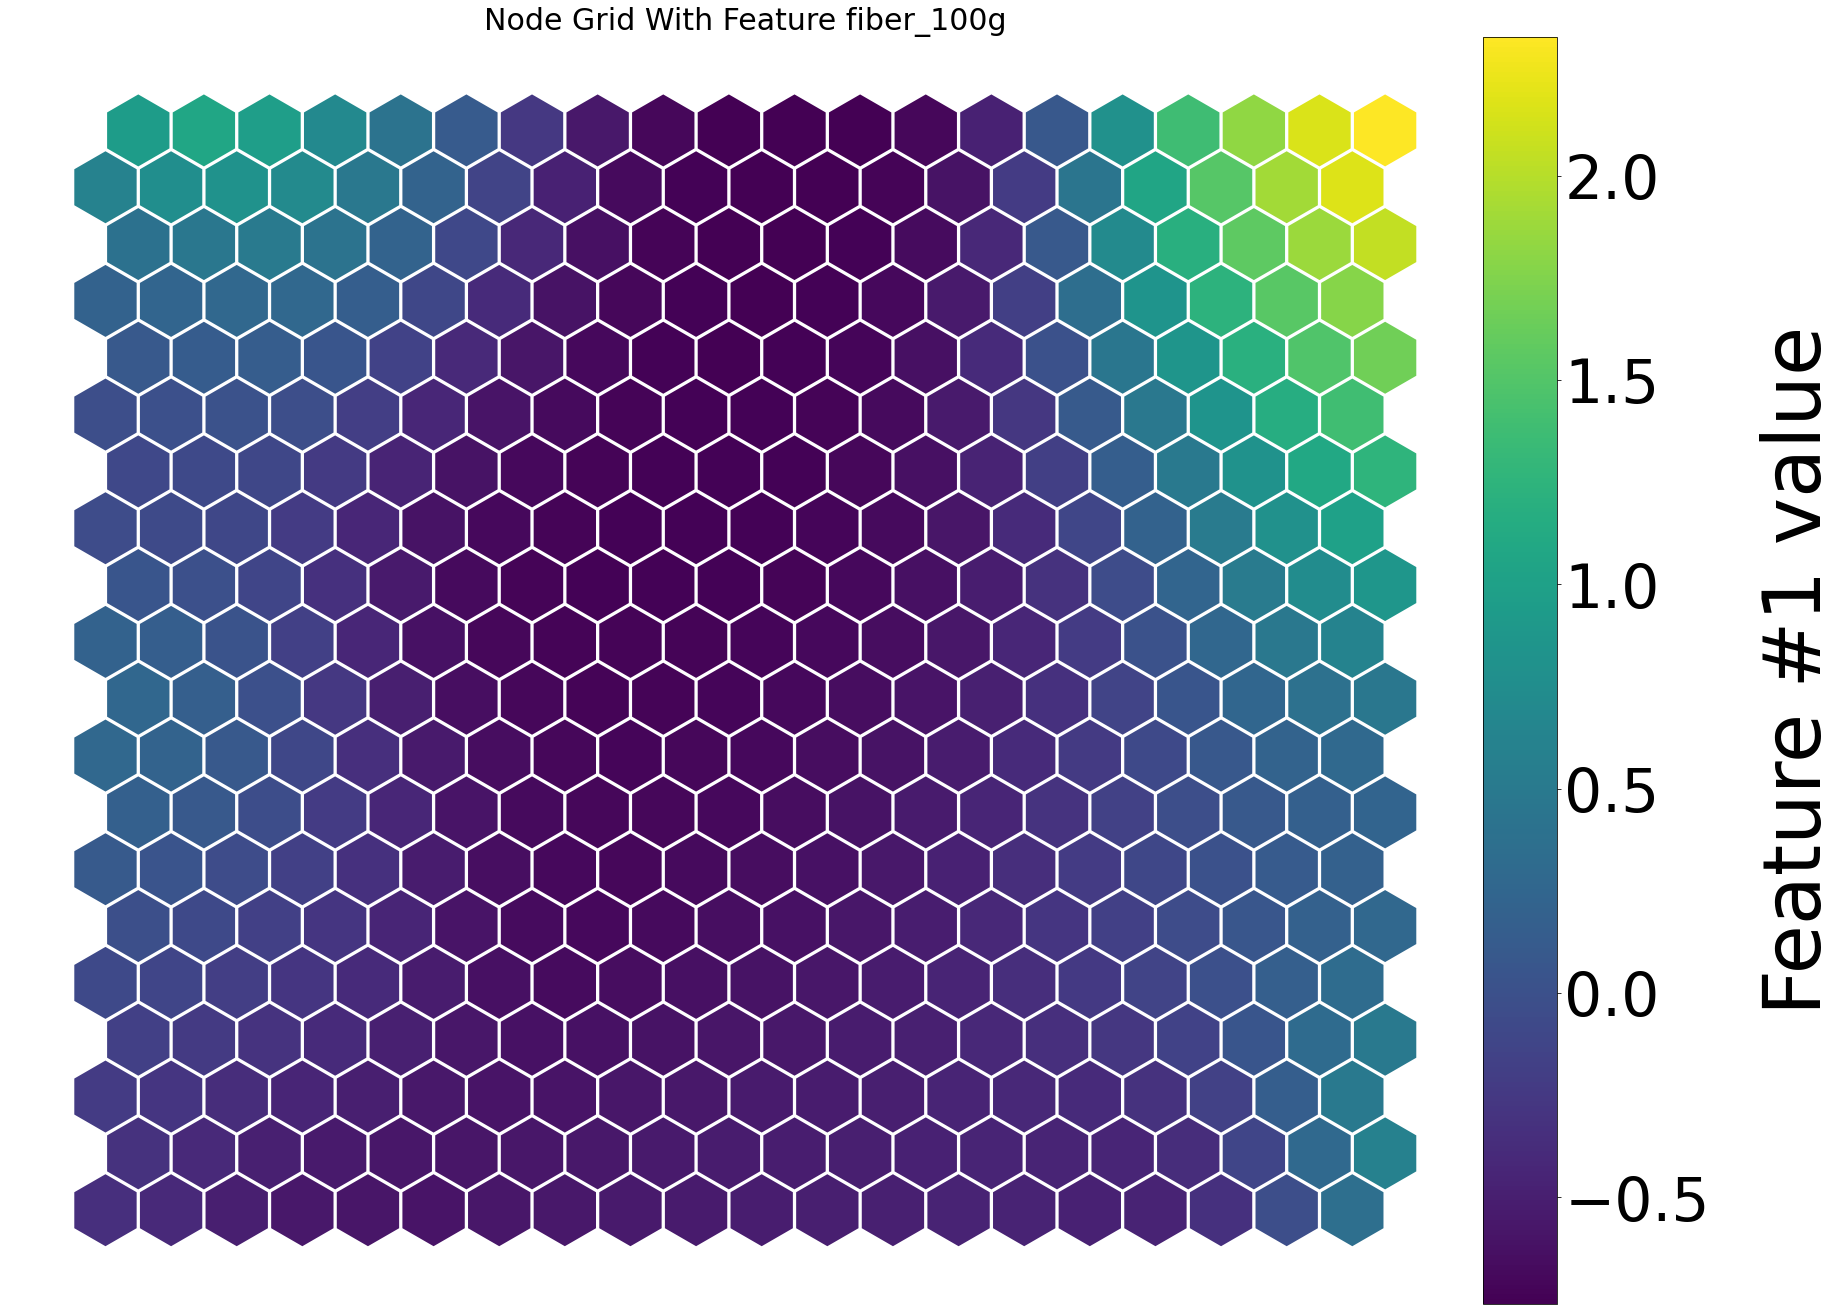

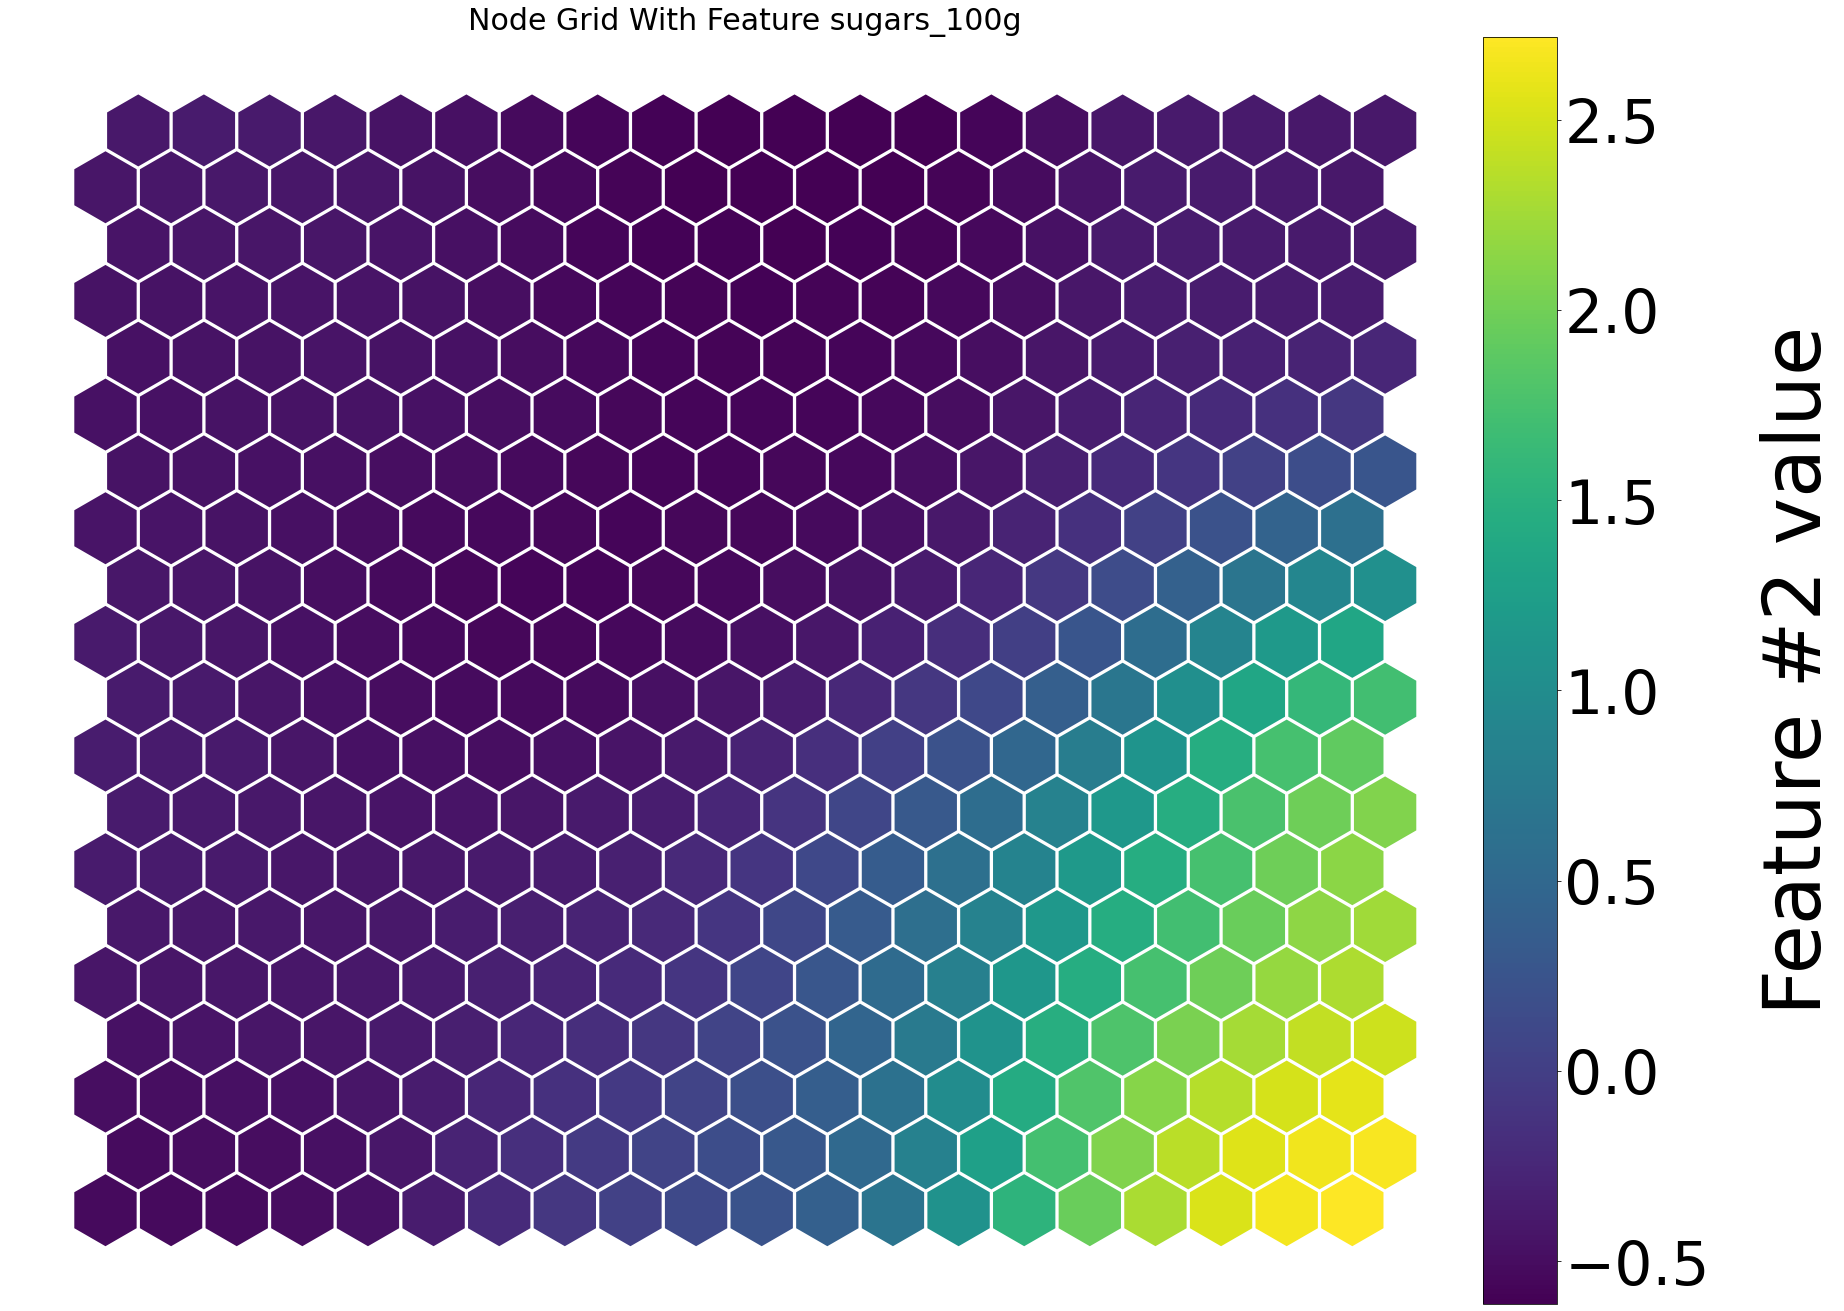

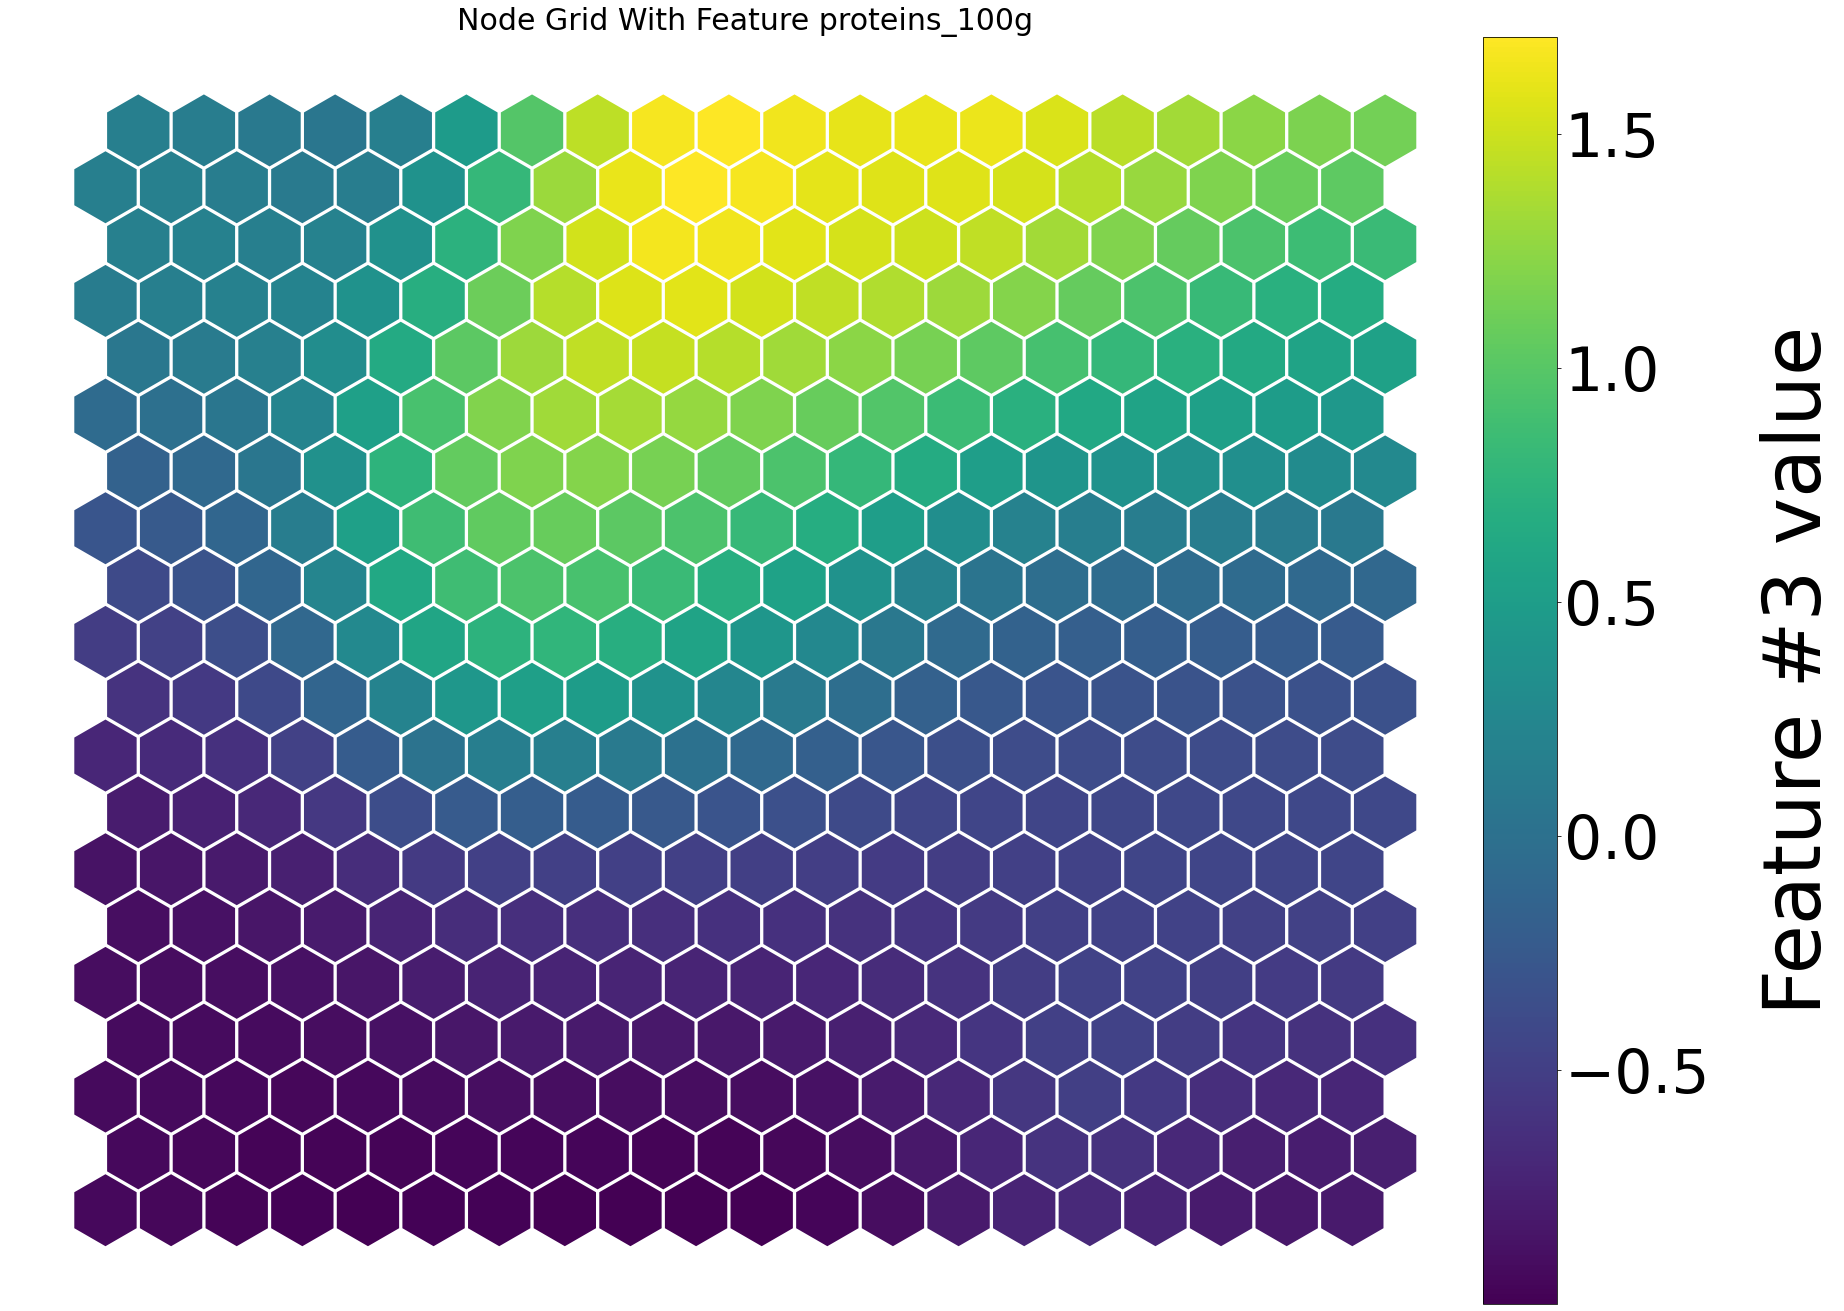

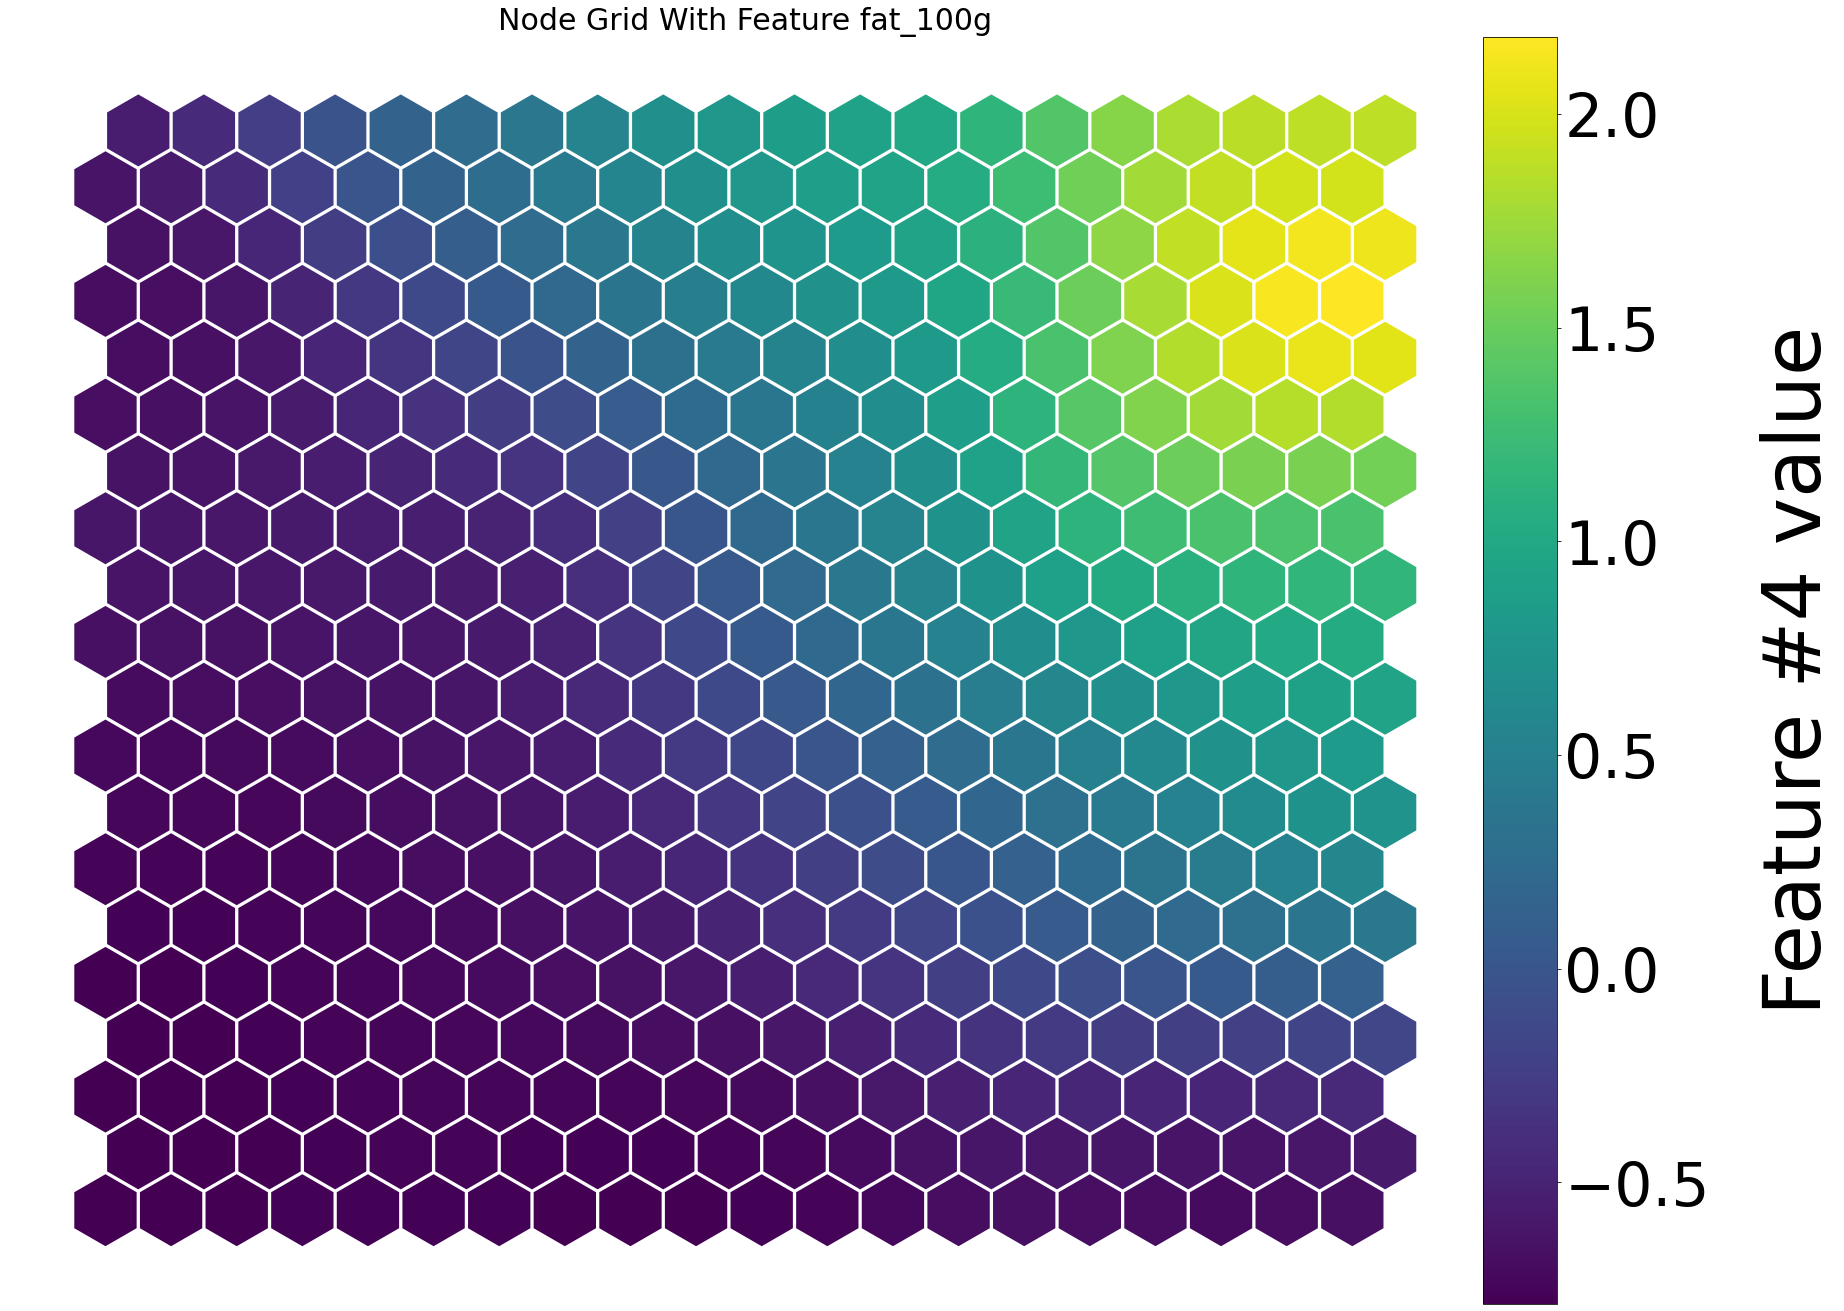

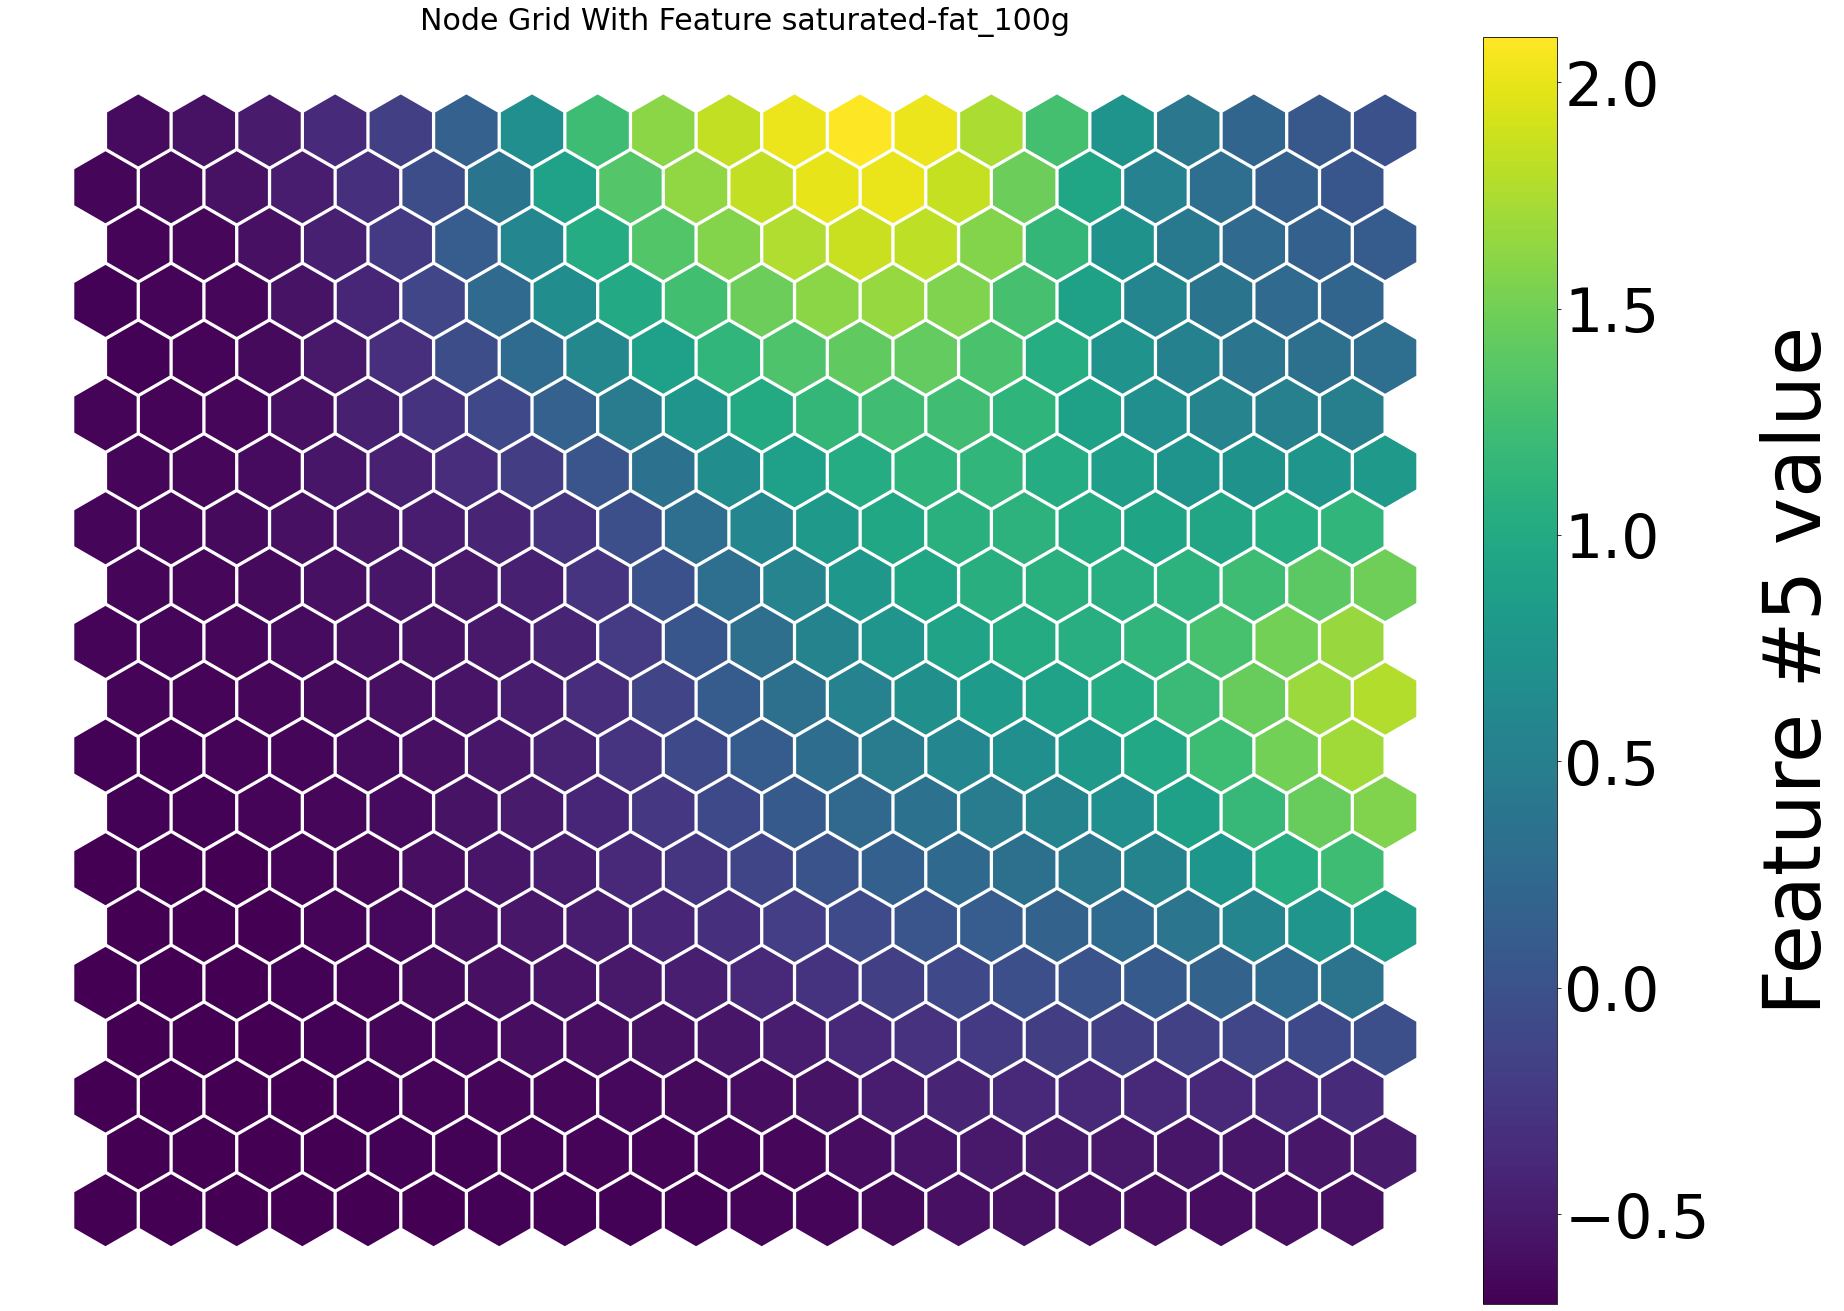

In [22]:
for i in range(0,len(clust_df.drop(["ingredients_text"], axis = 1).columns)):
    net.nodes_graph(colnum=i, printout=True)
    plt.title('Node Grid With Feature '+ clust_df.drop(["ingredients_text"], axis = 1).columns[i], size = 30)
    plt.show()

## Kmeans

In [23]:
scaledX = clust_df.iloc[:,1:]

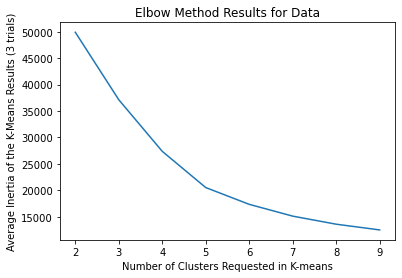

In [24]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.savefig('kmeansElbow.png')

In [25]:
n_clust = 5

In [26]:
X = np.array(clust_df.drop(["ingredients_text"], axis = 1))
kmeans = KMeans(n_clusters = n_clust, random_state = 69).fit(X)

In [27]:
clust_df['clust'] = kmeans.labels_


In [28]:
clust_df.groupby('clust').mean()

carbohydrates_100g  fiber_100g  sugars_100g  proteins_100g  fat_100g  \
clust                                                                         
0               -0.619592   -0.403674    -0.293389      -0.651319 -0.678733   
1               -0.851435   -0.747559    -0.565763       1.330765  0.704642   
2               -0.191268    1.853037    -0.327803       0.881821  1.936949   
3                1.430014    0.403714    -0.402082       0.047634 -0.459798   
4                1.376074    0.033427     2.223347      -0.567984 -0.074301   

       saturated-fat_100g  
clust                      
0               -0.596652  
1                1.549514  
2                0.214688  
3               -0.554970  
4                0.233992

In [29]:
clust_df.groupby('clust').count()

ingredients_text  carbohydrates_100g  fiber_100g  sugars_100g  \
clust                                                                  
0                  4970                4970        4970         4970   
1                  2129                2129        2129         2129   
2                  1491                1491        1491         1491   
3                  1922                1922        1922         1922   
4                  1765                1765        1765         1765   

       proteins_100g  fat_100g  saturated-fat_100g  
clust                                               
0               4970      4970                4970  
1               2129      2129                2129  
2               1491      1491                1491  
3               1922      1922                1922  
4               1765      1765                1765

#### WE USE TD-IDF TO DEFINE WORD PREVELANCE BY CLUSTER

In [30]:
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])


In [31]:
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [32]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [33]:
tot_word_counts = dict(Counter(all_words))

In [34]:
N = clust_df.shape[0]

In [35]:
def numDocExist(term):
    return (term in clust_word_counts0.keys()) + (term in clust_word_counts1.keys()) + \
(term in clust_word_counts2.keys()) + (term in clust_word_counts3.keys())+(term in clust_word_counts4.keys())

## Use most frequent words to define word prevelance by cluster 

In [36]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common(5))
    
#     ### TF IDF To Obtain True Cluster Prevelance 
#     for key in clust_word_counts.keys():
#         clust_word_counts[key] = clust_word_counts[key]/len(reduced_words)
    return clust_word_counts

In [37]:
clust_words = clust_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)

               ingredients_text
citric-acid               711.0
corn-syrup                365.0
milk                      345.0
ascorbic-acid             331.0
green-beans               330.0


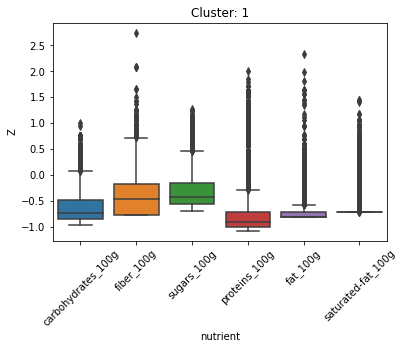

                            ingredients_text
enzymes                               1276.0
pasteurized-milk                       799.0
cheese-culture                         704.0
cheese-cultures                        342.0
pasteurized-part-skim-milk             312.0


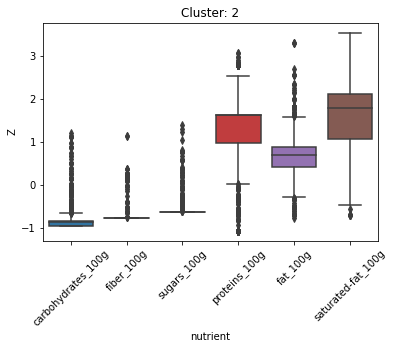

            ingredients_text
almonds                438.0
peanuts                300.0
pecans                 234.0
peanut-oil             219.0
walnuts                181.0


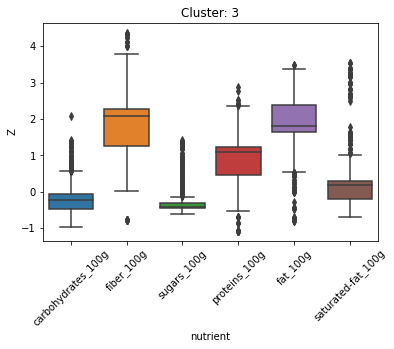

                 ingredients_text
niacin                      799.0
riboflavin                  777.0
folic-acid                  767.0
iron                        542.0
ferrous-sulfate             505.0


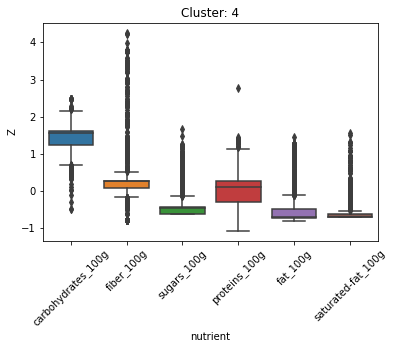

                  ingredients_text
corn-syrup                   545.0
soy-lecithin                 415.0
cocoa-butter                 384.0
citric-acid                  273.0
chocolate-liquor             259.0


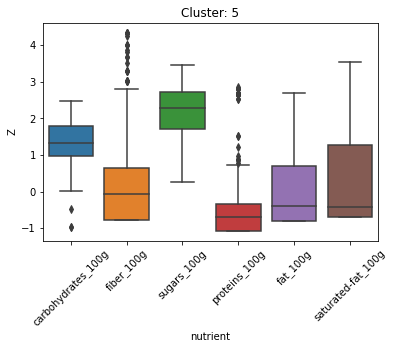

In [38]:
for c in range(n_clust):
    print(pd.DataFrame(clust_words[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.clust == c]
    plot_df = pd.DataFrame(temp_df.drop(['clust', 'ingredients_text'], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

## Hierarchical

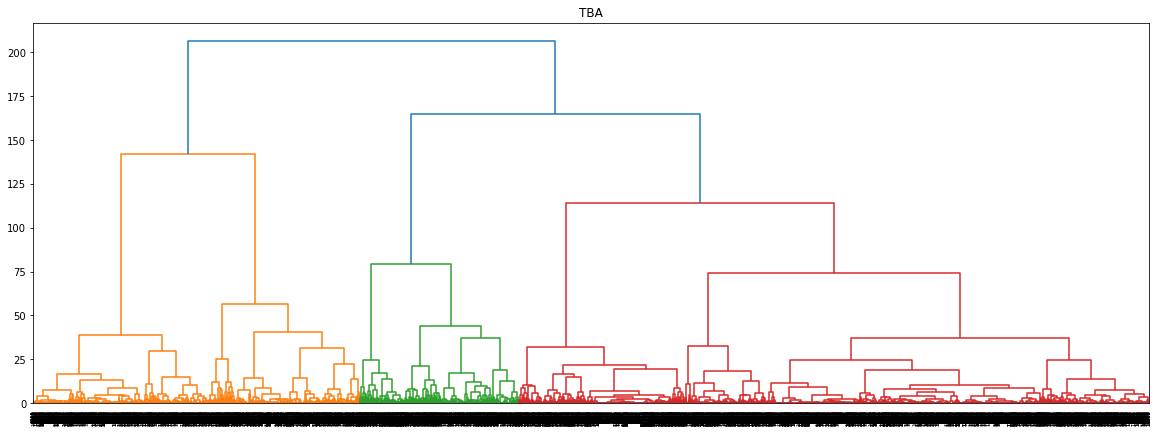

In [89]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("TBA")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(clust_df.drop(["ingredients_text", "clust"], axis = 1), method='ward'))

In [41]:
agc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

clust_df['hierarchical5'] = agc.fit_predict(clust_df.drop(["ingredients_text", "clust"], axis = 1))

In [42]:
clust_words2 = clust_df.groupby('hierarchical5')['ingredients_text'].apply(clust_word_prevelance)


                  ingredients_text
corn-syrup                   525.0
soy-lecithin                 414.0
cocoa-butter                 408.0
citric-acid                  272.0
chocolate-liquor             266.0


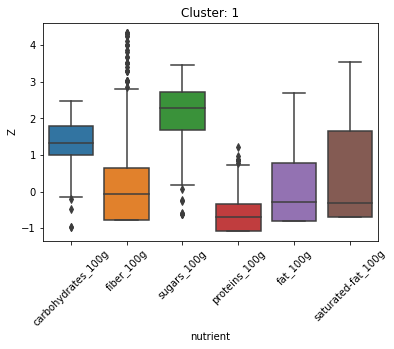

            ingredients_text
almonds                432.0
peanuts                302.0
pecans                 235.0
peanut-oil             223.0
walnuts                181.0


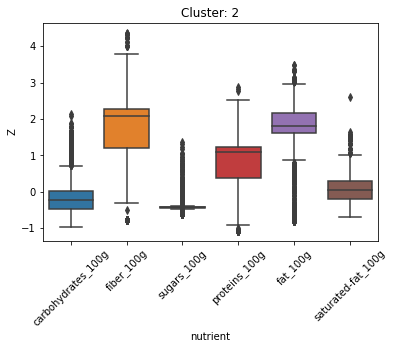

             ingredients_text
citric-acid             712.0
corn-syrup              376.0
milk                    356.0
vitamin-d3              335.0
green-beans             330.0


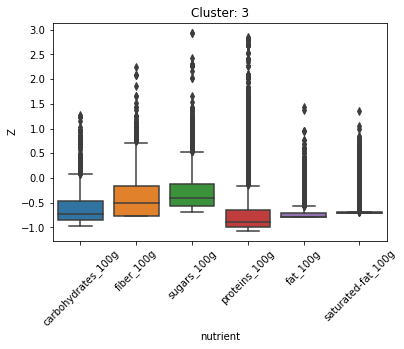

                            ingredients_text
enzymes                               1258.0
pasteurized-milk                       797.0
cheese-culture                         697.0
cheese-cultures                        330.0
pasteurized-part-skim-milk             296.0


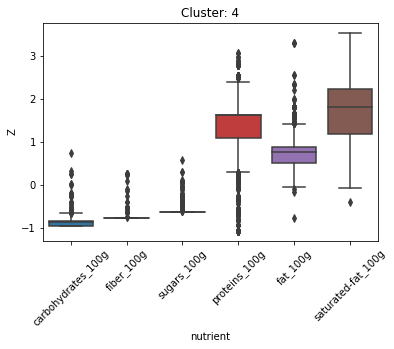

                 ingredients_text
niacin                      840.0
folic-acid                  818.0
riboflavin                  808.0
iron                        540.0
ferrous-sulfate             499.0


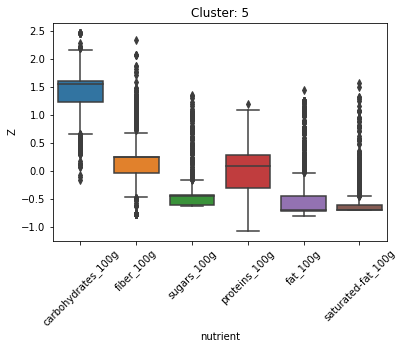

In [43]:
for c in range(5):
    print(pd.DataFrame(clust_words2[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.hierarchical5 == c]
    plot_df = pd.DataFrame(temp_df.drop(['hierarchical5', 'ingredients_text', "clust"], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

#### Looking at the carbonhydrate map, it suggests there exists two groups of observations with high carbonhydrate. One of them is highly proportionally correlated to sugar(c5 in kmeans) (c1 in hclust), while the other group is more correlated with fiber and protein.(c1 in kmeans) (c5 in hclust)

#### Looking at the fiber, protein, fat, saturated fat map, they suggests that fiber, protein, fat and saturated fat are somewhat proportionally correlated.  (c3, c4 in kmeans) (c4, c2 in hclust)


# Supervised Task

In [197]:
sup_df = clust_df.join(df[['additives', 'nutrition-score-fr_100g']]).dropna()

In [198]:
sup_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...            1.119606   
148                    cranberries sugar sunflower-oil            1.896869   
149                            apricots sulfur-dioxide            1.181114   
200  wheat-flour butter cream  water yeast sugar sa...            0.550919   
201  enriched-wheat-flour wheat-flour malted-barley...            0.656066   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  \
2      1.255472     0.371259       0.859435  0.137917           -0.700412   
148    2.083100     3.082730      -1.065403 -0.795579           -0.700412   
149    1.369627     2.295565      -0.795968 -0.795579           -0.700412   
200   -0.399784    -0.332580      -0.225846  0.086695            0.767782   
201   -0.513939     0.819560      -0.367029  0.027110           -0.177571   

     clust                                          additives  \
2        5   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...   
148      3   [ cranberries -> en:cranberries  ]  [ sugar -...   
149      3   [ apricots -> en:apricots  ]  [ sulfur-dioxid...   
200      5   [ wheat-flour -> en:wheat-flour  ]  [ flour -...   
201      5   [ enriched-wheat-flour -> en:enriched-wheat-f...   

     nutrition-score-fr_100g  
2                        0.0  
148                      8.0  
149                      8.0  
200                     18.0  
201                     14.0

## Is there a clear ranking of nutrition scores by cluster?

In [199]:
ranks = pd.DataFrame(sup_df.groupby('clust').mean()['nutrition-score-fr_100g']).sort_values('nutrition-score-fr_100g')
ranks.sort_values("nutrition-score-fr_100g")

nutrition-score-fr_100g
clust                         
5                     0.334542
1                     1.170208
6                     5.114522
4                     8.904300
3                    13.166827
2                    20.422587
0                    21.349800

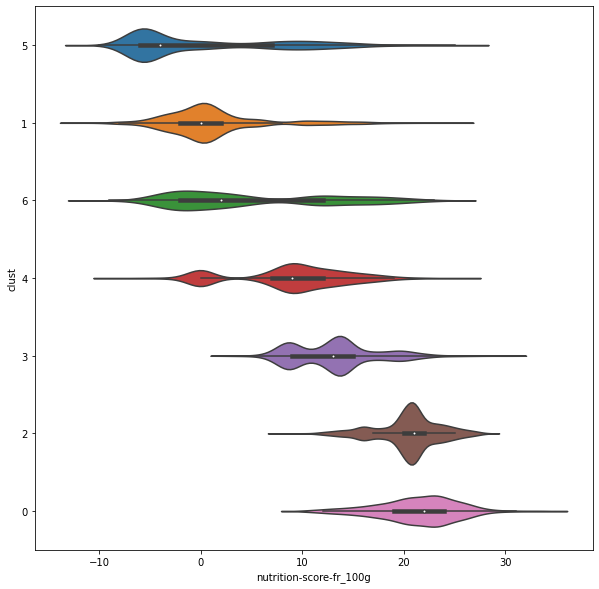

In [200]:
plt.figure(figsize = (10, 10))
sns.violinplot(data=sup_df, x = 'nutrition-score-fr_100g', y="clust", orient="h", order = [5, 1, 6, 4, 3, 2, 0])
plt.show()

Yes, there is clearly a ranking of nutrition scores by cluster.

## How well can clusters alone predict nutrition score?

First, we will make this a supremely easy task by splitting the nutrition score into binary categories. 

In [201]:
sup_df['nutrition-score-fr_100g'].describe()

count    12222.000000
mean         7.449435
std          9.623551
min        -12.000000
25%         -1.000000
50%          6.000000
75%         16.000000
max         34.000000
Name: nutrition-score-fr_100g, dtype: float64

In [202]:
sup_df['new_score'] = list(map(lambda x : 1 if x > 6 else 0, sup_df['nutrition-score-fr_100g']))
sup_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...            1.119606   
148                    cranberries sugar sunflower-oil            1.896869   
149                            apricots sulfur-dioxide            1.181114   
200  wheat-flour butter cream  water yeast sugar sa...            0.550919   
201  enriched-wheat-flour wheat-flour malted-barley...            0.656066   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  \
2      1.255472     0.371259       0.859435  0.137917           -0.700412   
148    2.083100     3.082730      -1.065403 -0.795579           -0.700412   
149    1.369627     2.295565      -0.795968 -0.795579           -0.700412   
200   -0.399784    -0.332580      -0.225846  0.086695            0.767782   
201   -0.513939     0.819560      -0.367029  0.027110           -0.177571   

     clust                                          additives  \
2        5   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...   
148      3   [ cranberries -> en:cranberries  ]  [ sugar -...   
149      3   [ apricots -> en:apricots  ]  [ sulfur-dioxid...   
200      5   [ wheat-flour -> en:wheat-flour  ]  [ flour -...   
201      5   [ enriched-wheat-flour -> en:enriched-wheat-f...   

     nutrition-score-fr_100g  new_score  
2                        0.0          0  
148                      8.0          1  
149                      8.0          1  
200                     18.0          1  
201                     14.0          1

In [203]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [204]:
X = sup_df['clust']
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [205]:
model = XGBClassifier()
model.fit(X_train.values.reshape(-1, 1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [206]:
y_pred = model.predict(X_test.values.reshape(-1, 1))
accuracy_score(y_test, y_pred)

0.8638036809815951

85% accuracy is not bad. Now, how can we use the clusters and text information to predict nutrition score?

# In case using cluster info is cheating, lets try regular TF_IDF

### EDIT: it is

In [207]:
sup_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...            1.119606   
148                    cranberries sugar sunflower-oil            1.896869   
149                            apricots sulfur-dioxide            1.181114   
200  wheat-flour butter cream  water yeast sugar sa...            0.550919   
201  enriched-wheat-flour wheat-flour malted-barley...            0.656066   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  \
2      1.255472     0.371259       0.859435  0.137917           -0.700412   
148    2.083100     3.082730      -1.065403 -0.795579           -0.700412   
149    1.369627     2.295565      -0.795968 -0.795579           -0.700412   
200   -0.399784    -0.332580      -0.225846  0.086695            0.767782   
201   -0.513939     0.819560      -0.367029  0.027110           -0.177571   

     clust                                          additives  \
2        5   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...   
148      3   [ cranberries -> en:cranberries  ]  [ sugar -...   
149      3   [ apricots -> en:apricots  ]  [ sulfur-dioxid...   
200      5   [ wheat-flour -> en:wheat-flour  ]  [ flour -...   
201      5   [ enriched-wheat-flour -> en:enriched-wheat-f...   

     nutrition-score-fr_100g  new_score  
2                        0.0          0  
148                      8.0          1  
149                      8.0          1  
200                     18.0          1  
201                     14.0          1

### Clean additives

In [208]:
clean_additives = lambda s: re.sub(r'[^a-z- ]+' , " ", s.lower().replace("en:","").replace("->","")).strip()
sup_df["additives"] = sup_df["additives"].apply(clean_additives)

In [209]:
sup_df.head()

ingredients_text  carbohydrates_100g  \
2    peanuts wheat-flour sugar rice-flour tapioca-s...            1.119606   
148                    cranberries sugar sunflower-oil            1.896869   
149                            apricots sulfur-dioxide            1.181114   
200  wheat-flour butter cream  water yeast sugar sa...            0.550919   
201  enriched-wheat-flour wheat-flour malted-barley...            0.656066   

     fiber_100g  sugars_100g  proteins_100g  fat_100g  saturated-fat_100g  \
2      1.255472     0.371259       0.859435  0.137917           -0.700412   
148    2.083100     3.082730      -1.065403 -0.795579           -0.700412   
149    1.369627     2.295565      -0.795968 -0.795579           -0.700412   
200   -0.399784    -0.332580      -0.225846  0.086695            0.767782   
201   -0.513939     0.819560      -0.367029  0.027110           -0.177571   

     clust                                          additives  \
2        5  peanuts  peanuts       wheat-flour  wheat-flou...   
148      3  cranberries  cranberries       sugar  sugar   ...   
149      3  apricots  apricots       sulfur-dioxide  e    ...   
200      5  wheat-flour  wheat-flour       flour  flour   ...   
201      5  enriched-wheat-flour  enriched-wheat-flour    ...   

     nutrition-score-fr_100g  new_score  
2                        0.0          0  
148                      8.0          1  
149                      8.0          1  
200                     18.0          1  
201                     14.0          1

### TF-IDF Additives

In [210]:
my_stop_words = set( stopwords.words('english')+ \
                    ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])

In [211]:
### Instantiate
vectorizer = text.TfidfVectorizer(strip_accents="unicode",stop_words=my_stop_words, \
                                  ngram_range=(1,1),max_features=30, \
                                  encoding="utf-8", token_pattern=r"(?u)\S\S+")

### Fit 
vectors = vectorizer.fit_transform(sup_df["additives"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

feature_names = ["ADD:" + fn for fn in feature_names]
df_additive_features = pd.DataFrame(dense, columns=feature_names)

df_additive_features.head()

ADD:--  ADD:acid  ADD:almonds  ADD:butter  ADD:cheese-culture  \
0  0.000000  0.000000          0.0    0.000000                 0.0   
1  0.000000  0.000000          0.0    0.000000                 0.0   
2  1.000000  0.000000          0.0    0.000000                 0.0   
3  0.106418  0.000000          0.0    0.432528                 0.0   
4  0.167177  0.204148          0.0    0.000000                 0.0   

   ADD:citric-acid  ADD:corn-syrup  ADD:cream  ADD:culture  ADD:enzymes  ...  \
0              0.0             0.0   0.000000          0.0     0.000000  ...   
1              0.0             0.0   0.000000          0.0     0.000000  ...   
2              0.0             0.0   0.000000          0.0     0.000000  ...   
3              0.0             0.0   0.462793          0.0     0.346258  ...   
4              0.0             0.0   0.000000          0.0     0.000000  ...   

   ADD:salt  ADD:sea-salt  ADD:semolina  ADD:soy-lecithin  ADD:starch  \
0  0.294725           0.0           0.0               0.0    0.671666   
1  0.000000           0.0           0.0               0.0    0.000000   
2  0.000000           0.0           0.0               0.0    0.000000   
3  0.195576           0.0           0.0               0.0    0.000000   
4  0.000000           0.0           0.0               0.0    0.233395   

   ADD:sugar  ADD:syrup  ADD:thiamin-mononitrate  ADD:water  ADD:wheat-flour  
0   0.194167        0.0                      0.0   0.198986         0.306027  
1   0.619826        0.0                      0.0   0.000000         0.000000  
2   0.000000        0.0                      0.0   0.000000         0.000000  
3   0.257694        0.0                      0.0   0.264089         0.406151  
4   0.134941        0.0                      0.0   0.138290         0.425361  

[5 rows x 30 columns]

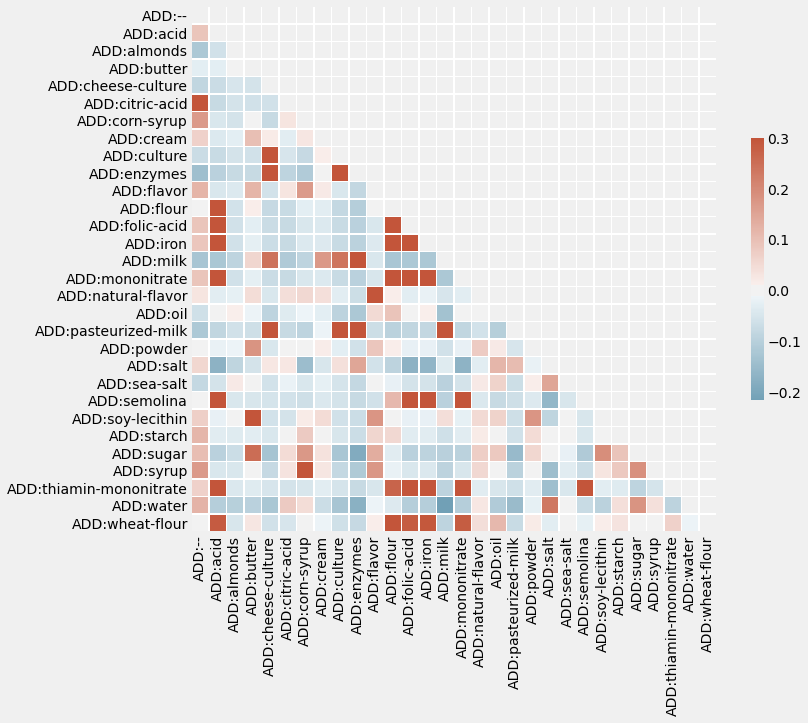

In [222]:
# Compute the correlation matrix
corr = df_additive_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### TF-IDF Ingredients

In [215]:
### Instantiate
vectorizer = text.TfidfVectorizer(strip_accents="unicode",stop_words=my_stop_words, \
                                  ngram_range=(1,1),max_features=30, \
                                  encoding="utf-8", token_pattern=r"(?u)\S\S+")

### Fit 
vectors = vectorizer.fit_transform(sup_df["ingredients_text"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

feature_names = ["ING:" + fn for fn in feature_names]
df_ingre_features = pd.DataFrame(dense, columns=feature_names)

df_ingre_features

ING:almonds  ING:cheese-culture  ING:citric-acid  ING:cocoa-butter  \
0              0.0                 0.0         0.000000               0.0   
1              0.0                 0.0         0.000000               0.0   
2              0.0                 0.0         0.000000               0.0   
3              0.0                 0.0         0.000000               0.0   
4              0.0                 0.0         0.000000               0.0   
...            ...                 ...              ...               ...   
12217          1.0                 0.0         0.000000               0.0   
12218          0.0                 0.0         0.000000               0.0   
12219          0.0                 0.0         0.544436               0.0   
12220          0.0                 0.0         0.000000               0.0   
12221          0.0                 0.0         0.000000               0.0   

       ING:corn  ING:corn-syrup  ING:cream  ING:dextrose  ING:enzymes  \
0           0.0             0.0   0.000000           0.0     0.000000   
1           0.0             0.0   0.000000           0.0     0.000000   
2           0.0             0.0   0.000000           0.0     0.000000   
3           0.0             0.0   0.554896           0.0     0.411416   
4           0.0             0.0   0.000000           0.0     0.000000   
...         ...             ...        ...           ...          ...   
12217       0.0             0.0   0.000000           0.0     0.000000   
12218       0.0             0.0   0.000000           0.0     0.000000   
12219       0.0             0.0   0.000000           0.0     0.000000   
12220       0.0             0.0   0.000000           0.0     0.000000   
12221       0.0             0.0   0.000000           0.0     0.000000   

       ING:ferrous-sulfate  ...  ING:sea-salt  ING:semolina  ING:soy-lecithin  \
0                      0.0  ...           0.0           0.0               0.0   
1                      0.0  ...           0.0           0.0               0.0   
2                      0.0  ...           0.0           0.0               0.0   
3                      0.0  ...           0.0           0.0               0.0   
4                      0.0  ...           0.0           0.0               0.0   
...                    ...  ...           ...           ...               ...   
12217                  0.0  ...           0.0           0.0               0.0   
12218                  0.0  ...           0.0           0.0               0.0   
12219                  0.0  ...           0.0           0.0               0.0   
12220                  0.0  ...           0.0           0.0               0.0   
12221                  0.0  ...           0.0           0.0               0.0   

       ING:spices  ING:sugar  ING:thiamin-mononitrate  \
0        0.000000   0.260082                      0.0   
1        0.000000   1.000000                      0.0   
2        0.000000   0.000000                      0.0   
3        0.000000   0.304961                      0.0   
4        0.000000   0.218663                      0.0   
...           ...        ...                      ...   
12217    0.000000   0.000000                      0.0   
12218    0.000000   0.000000                      0.0   
12219    0.682176   0.380248                      0.0   
12220    0.000000   0.000000                      0.0   
12221    0.000000   0.000000                      0.0   

       ING:thiamine-mononitrate  ING:water  ING:wheat  ING:wheat-flour  
0                      0.000000   0.267977   0.511788         0.443854  
1                      0.000000   0.000000   0.000000         0.000000  
2                      0.000000   0.000000   0.000000         0.000000  
3                      0.000000   0.314219   0.000000         0.520445  
4                      0.395347   0.225301   0.000000         0.373168  
...                         ...        ...        ...              ...  
12217                  0.000000   0.

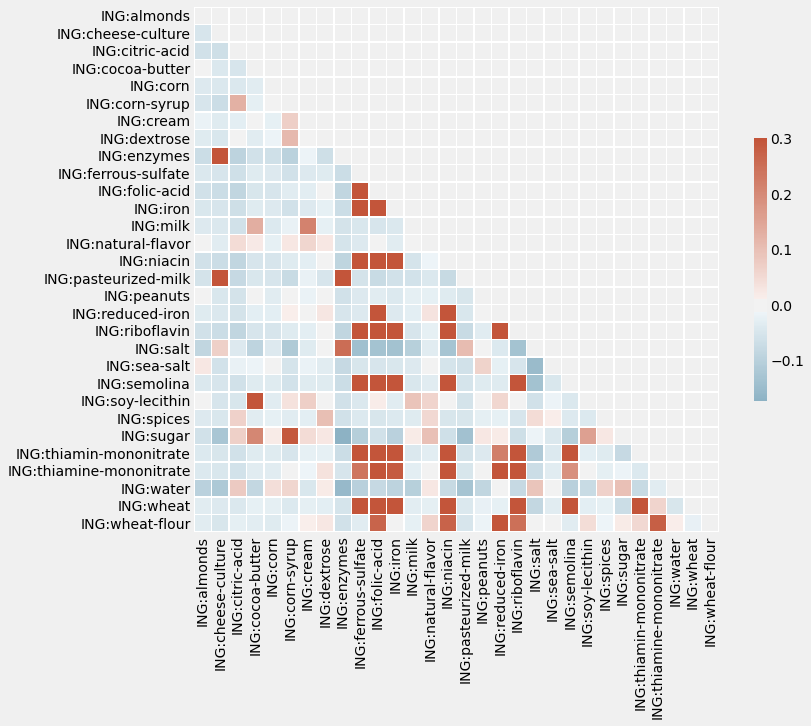

In [223]:
# Compute the correlation matrix
corr = df_ingre_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Concatenate 

In [217]:
df_feats = pd.concat([df_additive_features, df_ingre_features], axis=1)
df_feats = df_feats.drop(["ADD:--"], axis=1) # drop this, it's a garbage attribute

In [218]:
df_feats

ADD:acid  ADD:almonds  ADD:butter  ADD:cheese-culture  ADD:citric-acid  \
0      0.000000          0.0    0.000000                 0.0         0.000000   
1      0.000000          0.0    0.000000                 0.0         0.000000   
2      0.000000          0.0    0.000000                 0.0         0.000000   
3      0.000000          0.0    0.432528                 0.0         0.000000   
4      0.204148          0.0    0.000000                 0.0         0.000000   
...         ...          ...         ...                 ...              ...   
12217  0.000000          1.0    0.000000                 0.0         0.000000   
12218  0.000000          0.0    0.000000                 0.0         0.000000   
12219  0.000000          0.0    0.000000                 0.0         0.386262   
12220  0.000000          0.0    0.000000                 0.0         0.000000   
12221  0.000000          0.0    0.000000                 0.0         0.000000   

       ADD:corn-syrup  ADD:cream  ADD:culture  ADD:enzymes  ADD:flavor  ...  \
0                 0.0   0.000000          0.0     0.000000     0.00000  ...   
1                 0.0   0.000000          0.0     0.000000     0.00000  ...   
2                 0.0   0.000000          0.0     0.000000     0.00000  ...   
3                 0.0   0.462793          0.0     0.346258     0.00000  ...   
4                 0.0   0.000000          0.0     0.000000     0.20509  ...   
...               ...        ...          ...          ...         ...  ...   
12217             0.0   0.000000          0.0     0.000000     0.00000  ...   
12218             0.0   0.000000          0.0     0.000000     0.00000  ...   
12219             0.0   0.000000          0.0     0.000000     0.00000  ...   
12220             0.0   0.000000          0.0     0.000000     0.00000  ...   
12221             0.0   0.000000          0.0     0.000000     0.00000  ...   

       ING:sea-salt  ING:semolina  ING:soy-lecithin  ING:spices  ING:sugar  \
0               0.0           0.0               0.0    0.000000   0.260082   
1               0.0           0.0               0.0    0.000000   1.000000   
2               0.0           0.0               0.0    0.000000   0.000000   
3               0.0           0.0               0.0    0.000000   0.304961   
4               0.0           0.0               0.0    0.000000   0.218663   
...             ...           ...               ...         ...        ...   
12217           0.0           0.0               0.0    0.000000   0.000000   
12218           0.0           0.0               0.0    0.000000   0.000000   
12219           0.0           0.0               0.0    0.682176   0.380248   
12220           0.0           0.0               0.0    0.000000   0.000000   
12221           0.0           0.0               0.0    0.000000   0.000000   

       ING:thiamin-mononitrate  ING:thiamine-mononitrate  ING:water  \
0                          0.0                  0.000000   0.267977   
1                          0.0                  0.000000   0.000000   
2                          0.0                  0.000000   0.000000   
3                          0.0                  0.000000   0.314219   
4                          0.0                  0.395347   0.225301   
...                        ...                       ...        ...   
12217                      0.0                  0.000000   0.000000   
12218                      0.0                  0.000000   0.000000   
12219                      0.0                  0.000000   0.000000   
12220                      0.0                  0.000000   0.000000   
12221                      0.0                  0.000000   0.000000   

       ING:wheat  ING:wheat-flour  
0       0.511788         0.443854  
1       0.000000         0.000000  
2       0.000000         0.000000  
3       0.000000         0.520445  
4       0.000000         0.373168  
...          ...              ...  
12217   0.000000         0.000000  
12218  

## Truncated SVD

In [219]:
from sklearn.decomposition import TruncatedSVD
X = df_feats
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=69)
svd.fit(X)

TruncatedSVD(n_components=30, n_iter=7, random_state=69)

In [220]:
svd.explained_variance_ratio_.sum()

0.9653924264907495

Since 97% of the variance is still explained with only 30 features (probably because additives is dependent on ingredients), we can proceed with only 30 features.

In [76]:
X_new = svd.transform(X)

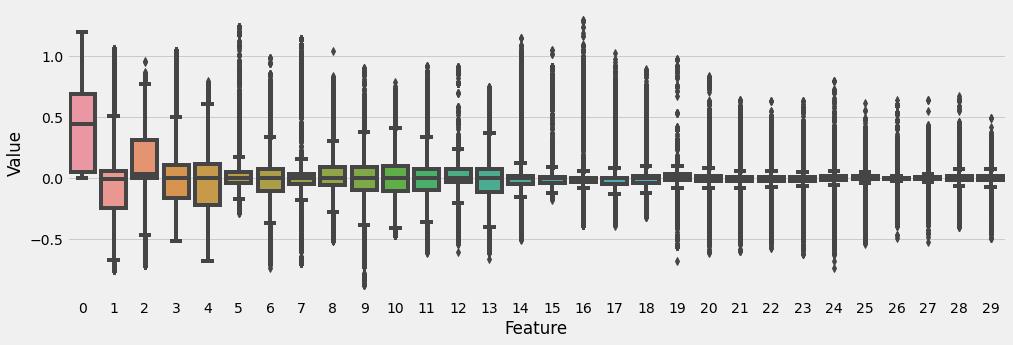

In [329]:
plt.figure(figsize = (15, 5))
feats = pd.DataFrame(pd.DataFrame(X_new).stack()).reset_index()
sns.boxplot(x = "level_1", y = 0, data = feats)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.show()

# Classification

In [312]:
X = X_new
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)
X_train.shape

(10388, 30)

## Logistic Regression with L1

In [123]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon

LR = LogisticRegression(penalty = "l1", max_iter=100, tol=1e-4, random_state=69, solver = 'saga')

dist = {"C" : expon()}

clf = RandomizedSearchCV(LR, dist, random_state=69)
search = clf.fit(X_train, y_train)

In [124]:
search.best_params_

{'C': 0.11090595621397231}

In [125]:
best_LR = search.best_estimator_

In [126]:
y_pred = best_LR.predict(X_train)
accuracy_score(y_train, y_pred)

0.8165190604543704

In [127]:
y_pred = best_LR.predict(X_test)
accuracy_score(y_test, y_pred)

0.806979280261723

## Random Forest

## Tuning

We use a randomized search with cross-validation for tuning our parameters

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [248]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [249]:
dist = {'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4)}

RF = RandomForestClassifier(random_state=69)

clf = RandomizedSearchCV(RF, dist, cv = 3, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [250]:
search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 702}

In [251]:
best_RF = search.best_estimator_

In [252]:
y_pred = best_RF.predict(X_train)
accuracy_score(y_train, y_pred)

0.8828455910666153

In [253]:
y_pred = best_RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.8527808069792803

## XGBoost

In [162]:
from scipy.stats import uniform

In [166]:
dist = {'eta' : uniform(0.01, 0.1), 
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10)}

XGB = XGBClassifier()

clf = RandomizedSearchCV(XGB, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [167]:
search.best_params_

{'eta': 0.045025252522341144, 'max_depth': 7, 'n_estimators': 661}

In [168]:
best_XGB = search.best_estimator_

In [169]:
y_pred = best_XGB.predict(X_train)
accuracy_score(y_train, y_pred)

0.8949749711205237

In [170]:
y_pred = best_XGB.predict(X_test)
accuracy_score(y_test, y_pred)

0.85659760087241

## ROC Curves (Train)

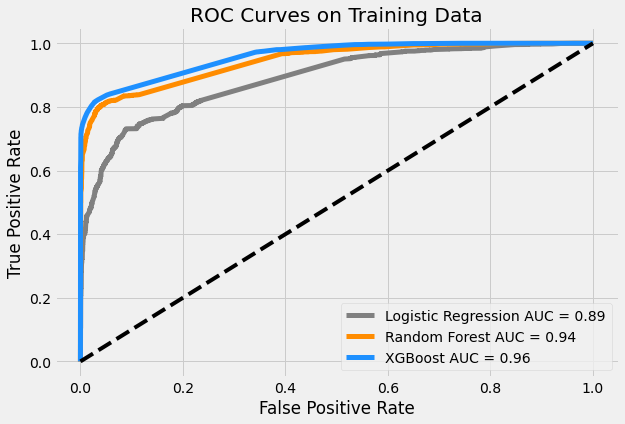

In [304]:
import sklearn.metrics as metrics

plt.figure(figsize=(9, 6))
plt.title('ROC Curves on Training Data')

### Logistic Regression
preds = best_LR.predict_proba(X_train)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Logistic Regression AUC = %0.2f' % roc_auc, color = "grey", linewidth = 5.0)

### Random Forest
preds = best_RF.predict_proba(X_train)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Random Forest AUC = %0.2f' % roc_auc, color = "darkorange", linewidth = 5.0)

### XGBoost
preds = best_XGB.predict_proba(X_train)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'XGBoost AUC = %0.2f' % roc_auc, color = "dodgerblue", linewidth = 5.0)
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "black")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ROC Curves (Test)

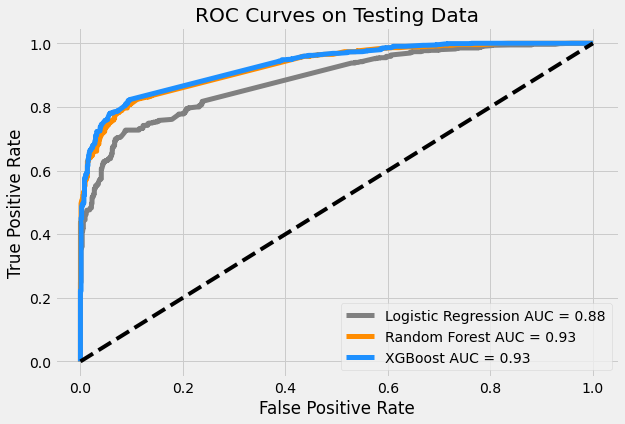

In [313]:
import sklearn.metrics as metrics

plt.figure(figsize=(9, 6))
plt.title('ROC Curves on Testing Data')

### Logistic Regression
preds = best_LR.predict_proba(X_test)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Logistic Regression AUC = %0.2f' % roc_auc, color = "grey", linewidth = 5.0)

### Random Forest
preds = best_RF.predict_proba(X_test)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Random Forest AUC = %0.2f' % roc_auc, color = "darkorange", linewidth = 5.0)

### XGBoost
preds = best_XGB.predict_proba(X_test)[ : , 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'XGBoost AUC = %0.2f' % roc_auc, color = "dodgerblue", linewidth = 5.0)
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "black")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Regression

In [305]:
X = X_new
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)
X_train.shape

(10388, 30)

## LASSO

## Tuning

We use a randomized search with cross-validation for tuning our parameters

In [172]:
from sklearn.model_selection import RandomizedSearchCV

In [174]:
from sklearn.linear_model import Lasso
from scipy.stats import expon

lasso = Lasso(max_iter=1000, tol=1e-4, random_state=69, selection="random")
dist = {"alpha" : expon()}

clf = RandomizedSearchCV(lasso, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [175]:
search.best_params_

{'alpha': 0.06023922086460815}

In [176]:
best_lasso = search.best_estimator_

In [177]:
y_pred = best_lasso.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

6.225150080599127

In [178]:
y_pred = best_lasso.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

6.000567092486989

## Random Forest

In [179]:
from sklearn.ensemble import RandomForestRegressor

In [231]:
dist = {'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4)}

RF = RandomForestRegressor(random_state=69)

clf = RandomizedSearchCV(RF, dist, cv = 3, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [232]:
search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 702}

In [233]:
best_RF_reg = search.best_estimator_

In [265]:
y_pred = best_RF_reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

4.677189438758958

In [266]:
y_pred = best_RF_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.996265438544345

array([-0.65569509, -6.54234465, -1.02784193, ..., -4.52237566,
        0.00941737, -7.64547798])

## XGBoost

In [189]:
dist = {'eta' : uniform(0.01, 0.1),
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10)}

XGB = XGBRegressor()

clf = RandomizedSearchCV(XGB, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [224]:
search.best_params_

{'eta': 0.05549061559669883, 'max_depth': 8, 'n_estimators': 277}

In [226]:
best_XGB_reg = search.best_estimator_

In [229]:
y_pred = best_XGB_reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

4.13288998994145

In [230]:
y_pred = best_XGB_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.805310789586715

## Residual Plot (Train)

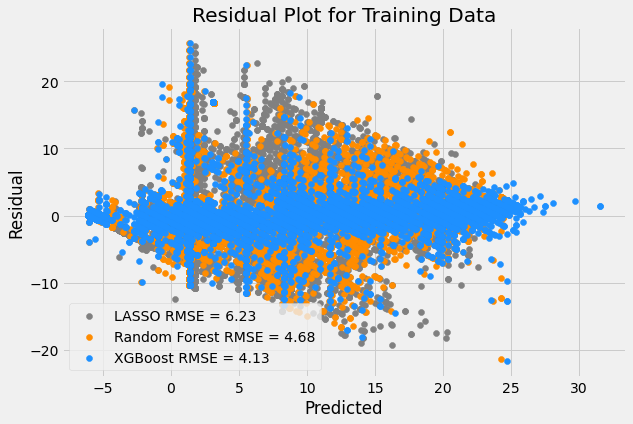

In [310]:
plt.figure(figsize=(9, 6))
plt.title("Residual Plot for Training Data")
y_true = np.array(y_train)

### LASSO
y_pred = best_lasso.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'LASSO RMSE = %0.2f' % rmse, color = "grey")

### Random Forest
y_pred = best_RF_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'Random Forest RMSE = %0.2f' % rmse, color = "darkorange")

### XGBoost
y_pred = best_XGB_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'XGBoost RMSE = %0.2f' % rmse, color = "dodgerblue")

plt.legend(loc = 'lower left')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

## Residual Plot (Test)

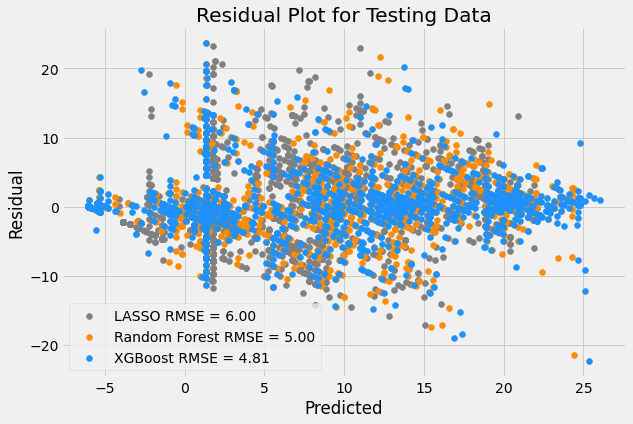

In [309]:
plt.figure(figsize=(9, 6))
plt.title("Residual Plot for Testing Data")
y_true = np.array(y_test)

### LASSO
y_pred = best_lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'LASSO RMSE = %0.2f' % rmse, color = "grey")

### Random Forest
y_pred = best_RF_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'Random Forest RMSE = %0.2f' % rmse, color = "darkorange")

### XGBoost
y_pred = best_XGB_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
plt.scatter(y_pred, y_true - y_pred, label = 'XGBoost RMSE = %0.2f' % rmse, color = "dodgerblue")

plt.legend(loc = 'lower left')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()